In [1]:
import json
from typing import List

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import targetpad_transform
from src.fashioniq_experiment.utils import element_wise_sum_original, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search, compute_results_fiq_val
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [2]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [3]:
BLIP_PRETRAINED_PATH = '../../../models/model_large_retrieval_flickr.pth'
MED_CONFIG_PATH = '../../blip_modules/med_config_large.json'

In [4]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True,
    vit='large',
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../../../models/model_large_retrieval_flickr.pth for text_encoder.
load checkpoint from ../../../models/model_large_retrieval_flickr.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [5]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH, vit='large')
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder.eval()

load checkpoint from ../../../models/model_large_retrieval_flickr.pth for visual_encoder.
load checkpoint from ../../../models/model_large_retrieval_flickr.pth for vision_proj.


blip img encoder loaded.

BLIPImgEncoder(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [6]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [7]:
combining_function_original = element_wise_sum_original

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [9]:
with open('../../../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 74357

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [10]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search(
        'shirt',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [11]:
display(shirt_recall_at10, shirt_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25       0.30  \
beta                                                                           
0.00   7.899902  7.899902  7.899902  7.899902  7.948969  7.998037   8.047105   
0.05   7.899902  7.899902  7.948969  7.899902  7.998037  8.145241   8.194308   
0.10   8.145241  8.243376  8.292443  8.292443  8.341511  8.586850   8.783121   
0.15   7.850834  7.998037  8.194308  8.292443  8.439647  8.635917   9.077527   
0.20   7.752699  7.899902  8.096173  8.390579  8.684985  8.979391   9.371933   
0.25   7.556428  7.752699  7.998037  8.390579  8.635917  9.175663   9.421001   
0.30   7.458293  7.752699  7.998037  8.292443  8.832189  9.224730   9.617272   
0.35   7.703631  8.047105  8.243376  8.684985  9.077527  9.519137   9.911678   
0.40   7.801767  7.850834  8.145241  8.734053  9.421001  9.911678  10.206085   
0.45   7.801767  7.948969  8.243376  8.488715  9.175663  9.568204  10.107949   
0.50   7.556428  7.850834  8.243376  8.635917  9.273798  9.617272  10.107949   
0.55   7.409225  7.605495  8.292443  8.635917  9.175663  9.715407  10.353287   
0.60   7.311089  7.507360  8.145241  8.832189  9.224730  9.862611  10.451423   
0.65   7.311089  7.752699  8.145241  8.684985  9.126595  9.764475  10.696761   
0.70   7.016683  7.409225  7.752699  8.194308  8.635917  9.126595  10.157017   
0.75   6.624141  6.918547  7.212954  7.850834  8.341511  9.126595   9.764475   
0.80   6.231600  6.476938  7.065751  7.556428  8.096173  8.586850   9.715407   
0.85   5.937193  6.231600  6.427871  7.262021  7.998037  8.488715   9.470069   
0.90   5.839058  5.986261  6.427871  7.065751  7.556428  8.292443   9.421001   
0.95   5.642787  5.789990  6.329735  6.820412  7.114819  8.194308   9.126595   
1.00   5.495584  5.740922  5.986261  6.329735  6.967615  7.801767   8.734053   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00    8.096173   8.096173   8.194308  ...   8.439647   8.783121   9.126595   
0.05    8.292443   8.439647   8.734053  ...   9.028459   9.224730   9.470069   
0.10    8.930324   9.028459   9.224730  ...   9.617272   9.960746  10.598626   
0.15    9.371933   9.666339   9.813543  ...  10.745829  11.236507  11.481845   
0.20    9.617272  10.009813  10.206085  ...  11.481845  11.825319  12.561335   
0.25    9.764475  10.107949  10.696761  ...  12.168793  12.806673  13.444553   
0.30   10.206085  10.500491  11.138371  ...  13.297351  13.738960  14.474976   
0.35   10.451423  10.893033  11.629048  ...  13.738960  14.671247  15.505397   
0.40   10.794897  11.138371  12.365064  ...  14.524043  15.407263  16.732091   
0.45   10.598626  11.727183  12.953876  ...  15.210991  16.633955  17.909716   
0.50   10.843965  12.365064  13.395485  ...  16.388616  17.468105  18.792935   
0.55   11.285574  12.315996  13.788028  ...  16.830225  18.253189  19.921492   
0.60   11.629048  12.708537  13.984299  ...  17.222768  18.645731  20.755643   
0.65   11.383709  12.855741  14.082433  ...  17.517173  19.627085  20.902845   
0.70   11.138371  12.561335  14.033367  ...  17.713444  19.381747  21.148184   
0.75   10.991168  12.463199  14.131501  ...  17.173700  19.479883  21.393523   
0.80   10.647694  12.512267  13.886163  ...  17.419039  19.332679  21.295388   
0.85   10.451423  12.463199  14.082433  ...  17.713444  19.725221  21.050049   
0.90   10.353287  11.727183  13.886163  ...  17.762512  19.430815  20.902845   
0.95   10.009813  11.432777  13.886163  ...  17.664377  18.940137  20.314033   
1.00    9.519137  11.040235  13.297351  ...  16.830225  18.743867  19.676153   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    9.519137  10.009813  10.991168  12.414131  15.701668  23.994112   
0.05   10.304220  11.040235  11.874387  13.886163  17.271835  25.368008   
0.10   11.138371  

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   17.762512  17.811580  17.811580  17.958783  18.056919  18.155053   
0.05   17.909716  18.007851  18.253189  18.400392  18.547596  18.694799   
0.10   18.596664  18.743867  18.989205  19.234544  19.479883  19.627085   
0.15   18.792935  19.087340  19.381747  19.528949  19.872424  20.117763   
0.20   18.891069  19.185476  19.381747  19.872424  20.608440  21.050049   
0.25   19.038273  19.332679  19.823356  20.215897  20.804711  21.295388   
0.30   18.842001  19.283612  19.872424  20.215897  20.853779  21.491659   
0.35   18.596664  19.332679  19.578017  20.314033  20.804711  21.736997   
0.40   18.253189  19.038273  19.479883  20.019627  20.902845  21.540727   
0.45   17.811580  18.498528  19.283612  19.774288  20.657508  21.835132   
0.50   17.517173  18.105987  18.842001  19.627085  20.706575  21.835132   
0.55   17.320903  17.958783  18.792935  19.283612  20.363101  21.638861   
0.60   16.388616  17.468105  18.547596  19.234544  20.264965  21.589793   
0.65   15.750736  16.879293  17.468105  18.842001  20.068695  21.344456   
0.70   15.358195  15.996075  17.271835  18.449460  19.774288  21.246320   
0.75   15.063788  15.603533  16.584887  17.468105  19.185476  20.559372   
0.80   14.474976  15.112856  16.143277  17.075564  18.596664  19.970560   
0.85   14.131501  14.867517  15.358195  16.094211  18.105987  19.430815   
0.90   13.591756  14.229637  14.720315  15.897939  17.173700  18.792935   
0.95   12.953876  13.640824  14.524043  15.407263  16.683023  17.909716   
1.00   12.610403  13.199215  14.229637  15.260059  16.094211  17.517173   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   18.253189  18.449460  18.596664  18.842001  ...  19.038273  19.381747   
0.05   18.792935  18.989205  19.185476  19.381747  ...  19.872424  20.215897   
0.10   19.774288  20.068695  20.264965  20.510304  ...  21.050049  21.540727   
0.15   20.608440  20.951913  21.393523  21.491659  ...  22.178607  22.620216   
0.20   21.295388  21.736997  21.835132  22.374877  ...  23.748773  24.582924   
0.25   21.933268  22.325809  22.571148  23.601571  ...  25.122669  25.809616   
0.30   22.129539  22.571148  23.405299  24.386653  ...  26.005888  27.232581   
0.35   22.473013  23.159961  24.092247  24.779195  ...  27.330717  28.606477   
0.40   22.522080  23.846909  24.681060  25.269872  ...  28.410205  30.078509   
0.45   22.767419  23.846909  24.828263  25.956821  ...  30.176643  31.697744   
0.50   22.718351  23.945044  25.220805  26.938176  ...  31.354269  32.924435   
0.55   22.767419  24.190383  25.858685  27.526987  ...  32.335624  34.347400   
0.60   22.963689  24.337585  26.005888  28.263003  ...  32.777232  35.328755   
0.65   23.061825  24.582924  26.104024  28.999019  ...  33.169773  36.359176   
0.70   22.865555  24.681060  26.054955  29.195291  ...  33.856723  36.702651   
0.75   22.276741  24.092247  26.251227  29.244357  ...  34.641805  37.144259   
0.80   21.786065  23.601571  26.398429  29.293424  ...  34.985280  37.046123   
0.85   21.393523  23.601571  26.349363  29.342493  ...  34.739941  36.310107   
0.90   20.608440  23.159961  26.153091  29.342493  ...  34.052992  35.525024   
0.95   20.019627  23.012757  25.809616  29.097155  ...  33.464181  35.181549   
1.00   19.921492  22.669284  25.269872  28.164867  ...  33.071640  34.151128   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   19.725221  20.264965  21.000981  22.031404  24.533857  28.655544   
0.05   20.853779  21.442591  22.227675  23.601571  25.907752  30.765456   
0.10   22.080471  22.571148  23.699705  25.269872  27.723259  33.169773   
0.15   23.552503  24.435721  25.613347  27.134445  29.2934

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [12]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search(
        'dress',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   3.718394  3.718394  3.767972  3.767972  3.767972  3.767972  3.767972   
0.05   3.718394  3.718394  3.718394  3.767972  3.817551  3.966286  3.966286   
0.10   3.966286  3.966286  4.015865  4.015865  4.015865  4.115022  4.164601   
0.15   4.214180  4.214180  4.263758  4.313337  4.462072  4.511651  4.561229   
0.20   4.015865  4.065444  4.263758  4.313337  4.462072  4.511651  4.511651   
0.25   4.015865  4.015865  4.115022  4.164601  4.263758  4.263758  4.362915   
0.30   3.867129  3.916708  3.867129  4.065444  4.115022  4.313337  4.462072   
0.35   3.619236  3.817551  3.718394  3.767972  4.164601  4.263758  4.362915   
0.40   3.470501  3.470501  3.569658  3.767972  4.214180  4.362915  4.362915   
0.45   3.371344  3.470501  3.619236  3.569658  3.817551  4.015865  4.263758   
0.50   3.073872  3.173029  3.222608  3.371344  3.767972  3.966286  4.362915   
0.55   2.825979  2.875558  3.024293  3.371344  3.520079  3.817551  4.362915   
0.60   2.925136  2.974715  2.925136  3.073872  3.222608  3.668815  4.115022   
0.65   2.677243  2.875558  2.925136  3.024293  3.222608  3.619236  4.015865   
0.70   2.627665  2.627665  2.726822  2.925136  3.123451  3.619236  4.015865   
0.75   2.478929  2.478929  2.677243  2.825979  3.222608  3.420922  3.916708   
0.80   2.379772  2.528508  2.578086  2.726822  3.073872  3.371344  3.767972   
0.85   2.181458  2.280615  2.429350  2.627665  3.024293  3.173029  3.619236   
0.90   2.131879  2.181458  2.330193  2.726822  2.925136  3.024293  3.173029   
0.95   2.032722  2.032722  2.131879  2.330193  2.627665  2.875558  3.073872   
1.00   1.883986  1.883986  2.131879  2.280615  2.478929  2.677243  2.875558   

alpha      0.35      0.40      0.45  ...      0.55       0.60       0.65  \
beta                                 ...                                   
0.00   3.817551  3.867129  3.966286  ...  4.214180   4.263758   4.263758   
0.05   3.966286  3.966286  4.065444  ...  4.263758   4.313337   4.561229   
0.10   4.115022  4.214180  4.263758  ...  4.462072   4.610808   4.908280   
0.15   4.511651  4.709965  4.858701  ...  4.809123   5.156172   5.453644   
0.20   4.610808  4.957858  4.809123  ...  5.156172   5.552801   6.147744   
0.25   4.561229  4.759544  4.809123  ...  5.552801   6.098166   6.593952   
0.30   4.660387  4.759544  4.759544  ...  5.800694   6.445216   6.941001   
0.35   4.660387  4.809123  4.957858  ...  6.147744   6.742688   7.635102   
0.40   4.462072  4.709965  5.255330  ...  6.693108   7.337630   8.577095   
0.45   4.462072  4.858701  5.552801  ...  7.288051   8.378781   9.419931   
0.50   4.660387  5.156172  5.552801  ...  7.585523   8.874566   9.965295   
0.55   4.908280  5.453644  5.651958  ...  7.982152   9.320773  11.006445   
0.60   5.007437  5.354487  5.751115  ...  7.833416   9.965295  11.353495   
0.65   4.759544  5.304908  5.949430  ...  8.230045  10.213188  11.502231   
0.70   4.561229  4.858701  5.800694  ...  8.824988  10.411502  11.551809   
0.75   4.313337  4.561229  5.701537  ...  8.577095  10.461081  12.097174   
0.80   4.115022  4.462072  5.602380  ...  8.874566  10.411502  11.799703   
0.85   4.065444  4.709965  5.503223  ...  8.874566  10.064452  11.551809   
0.90   3.966286  4.660387  5.552801  ...  8.725830  10.213188  11.254338   
0.95   4.015865  4.660387  5.453644  ...  8.378781   9.618245  10.510659   
1.00   3.668815  4.561229  5.503223  ...  7.684680   9.271195   9.965295   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    4.462072   5.106594   5.701537   7.089737  10.411502  18.939018   
0.05    4.908280   5.552801   6.445216   7.932573  11.353495  20.178483   
0.10    5.304908   6.395637   7.188895   9.072880  12.097174  20.971741   
0.15    5.999009   6.544373   7.932573   9.866138  13.3862

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   11.254338  11.254338  11.254338  11.502231  11.700545  11.750124   
0.05   11.601388  11.750124  11.898860  11.998017  12.047596  12.047596   
0.10   11.403074  11.601388  11.799703  11.849281  11.998017  12.196331   
0.15   11.105602  11.303917  11.452653  11.898860  12.047596  12.394646   
0.20   10.808131  11.056024  11.601388  11.849281  12.245910  12.444224   
0.25   10.461081  10.857709  11.155181  11.452653  11.898860  12.196331   
0.30   10.114031  10.461081  10.758552  11.403074  11.898860  12.493803   
0.35    9.915716  10.114031  10.510659  11.204760  11.898860  12.692118   
0.40    9.816559  10.163610  10.510659  11.056024  11.601388  12.295488   
0.45    9.618245  10.114031  10.510659  10.956866  11.551809  12.097174   
0.50    9.519088   9.766981  10.163610  10.659395  11.353495  12.146752   
0.55    9.519088   9.816559  10.114031  10.708974  11.403074  11.601388   
0.60    9.320773   9.519088   9.866138  10.461081  10.956866  11.650967   
0.65    8.874566   9.221616   9.568667  10.262766  10.857709  11.601388   
0.70    8.428359   8.676252   9.122459   9.965295  10.708974  11.601388   
0.75    8.081309   8.378781   8.775409   9.370352  10.312345  11.155181   
0.80    7.684680   8.031730   8.378781   9.122459   9.766981  10.708974   
0.85    7.436787   7.932573   8.279623   8.477937   9.271195  10.163610   
0.90    7.288051   7.635102   8.031730   8.428359   9.023302  10.064452   
0.95    7.040159   7.486366   7.882994   8.031730   8.725830   9.667823   
1.00    6.990580   7.188895   7.635102   7.684680   8.477937   9.221616   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   11.849281  11.998017  11.998017  12.047596  ...  12.642539  12.989588   
0.05   12.047596  12.295488  12.345067  12.642539  ...  13.386217  13.733268   
0.10   12.394646  12.692118  12.989588  13.287060  ...  14.328210  14.774418   
0.15   12.989588  13.287060  13.584532  14.030738  ...  15.171047  15.765989   
0.20   12.890431  13.485375  14.179474  14.576103  ...  16.063461  16.856718   
0.25   13.138324  13.882002  14.476946  15.369360  ...  16.757561  17.798711   
0.30   13.039167  13.832425  14.724839  15.716411  ...  17.848289  18.691126   
0.35   13.336639  13.832425  15.022311  15.815568  ...  18.294497  19.930591   
0.40   13.039167  13.882002  14.923154  16.162618  ...  19.186911  20.376797   
0.45   12.741695  13.683689  15.121467  16.360933  ...  19.633119  21.913733   
0.50   12.840852  13.981161  15.071888  16.360933  ...  20.327219  22.607833   
0.55   12.741695  14.129896  15.270203  17.253347  ...  21.021318  23.202777   
0.60   12.444224  13.832425  15.270203  17.203768  ...  21.814576  23.500247   
0.65   12.196331  13.683689  15.468517  17.352504  ...  22.012891  24.045612   
0.70   11.948438  13.435796  15.468517  17.055032  ...  21.814576  23.996034   
0.75   11.849281  13.287060  15.071888  16.856718  ...  21.864155  23.847298   
0.80   11.403074  12.592959  14.526525  16.807139  ...  21.417947  23.500247   
0.85   11.254338  12.245910  14.229053  16.460089  ...  21.070898  23.549826   
0.90   10.857709  12.146752  13.584532  16.113040  ...  20.376797  22.359940   
0.95   10.510659  11.601388  13.138324  15.468517  ...  19.881012  21.517104   
1.00    9.965295  11.303917  12.345067  14.873575  ...  19.087754  20.823005   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   13.485375  13.981161  14.724839  15.914725  18.591969  24.987605   
0.05   14.229053  14.724839  15.964304  17.699553  20.525533  27.615270   
0.10   15.518096  16.311353  17.550819  19.484383  22.706990  30.094200   
0.15   16.509669  17.798711  18.889439  21.170054  24.5909

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search(
        'toptee',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
display(toptee_recall_at10, toptee_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.578276  6.578276  6.680265  6.680265  6.782254  6.884243  6.986231   
0.05   6.527282  6.629271  6.782254  6.782254  6.782254  6.986231  7.088220   
0.10   6.527282  6.578276  6.731260  6.986231  6.986231  7.037226  7.445181   
0.15   6.476288  6.578276  6.680265  6.833249  6.986231  7.088220  7.343192   
0.20   6.323305  6.527282  6.833249  6.935237  7.139215  7.292198  7.547170   
0.25   6.170321  6.374299  6.680265  6.884243  7.088220  7.292198  7.904130   
0.30   6.170321  6.221316  6.425294  6.629271  7.139215  7.496175  8.108108   
0.35   5.813361  5.915349  6.221316  6.527282  6.986231  7.598164  8.057114   
0.40   5.609383  5.915349  6.272310  6.578276  6.935237  7.445181  7.955125   
0.45   5.558389  5.762366  6.170321  6.578276  6.935237  7.496175  8.159102   
0.50   5.150434  5.558389  5.813361  6.272310  6.782254  7.700153  8.312086   
0.55   5.099439  5.252422  5.660377  6.170321  6.731260  7.343192  8.006119   
0.60   4.844467  4.895461  5.354411  5.660377  6.476288  7.088220  7.853136   
0.65   4.589495  4.793473  5.150434  5.711372  6.272310  6.884243  7.700153   
0.70   4.436512  4.538501  4.946456  5.456400  6.170321  6.782254  7.547170   
0.75   4.079551  4.436512  4.742478  5.099439  6.017338  6.833249  7.241204   
0.80   4.028557  4.334523  4.640489  5.099439  5.711372  6.527282  7.241204   
0.85   3.620602  4.028557  4.640489  5.048444  5.660377  6.374299  7.037226   
0.90   3.518613  3.926568  4.385518  4.946456  5.762366  6.017338  7.037226   
0.95   3.314636  3.926568  4.334523  4.793473  5.609383  5.813361  6.935237   
1.00   3.110658  3.569607  3.977562  4.640489  5.201428  5.558389  6.578276   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   7.139215   7.139215   7.190209  ...   7.496175   7.751147   8.159102   
0.05   7.241204   7.496175   7.547170  ...   8.108108   8.312086   8.618052   
0.10   7.547170   7.700153   7.904130  ...   8.567058   8.975013   9.127996   
0.15   7.802141   8.057114   8.414075  ...   8.975013   9.484956  10.147884   
0.20   7.853136   8.312086   8.720041  ...   9.484956  10.147884  11.167771   
0.25   8.414075   8.516064   8.975013  ...  10.708822  11.371749  12.850587   
0.30   8.720041   9.026007   9.331974  ...  11.524732  12.595615  14.023457   
0.35   8.516064   9.026007   9.535951  ...  12.391637  13.462520  15.247323   
0.40   8.465069   9.127996  10.045895  ...  12.850587  14.686385  16.573177   
0.45   8.669046   9.433962  10.300867  ...  13.921468  15.808260  18.001020   
0.50   8.771035   9.433962  10.912800  ...  14.839368  16.981132  19.224885   
0.55   8.924019   9.637940  11.422744  ...  15.298317  17.848037  20.397756   
0.60   8.975013   9.994900  11.575726  ...  16.114227  18.561958  21.009690   
0.65   8.618052  10.045895  11.728710  ...  16.981132  19.020908  21.570627   
0.70   8.363080   9.892911  11.881693  ...  16.930138  19.479857  21.774605   
0.75   8.159102   9.943906  12.289649  ...  17.185110  19.632840  21.264660   
0.80   8.261091  10.045895  12.136665  ...  17.338093  19.734830  21.672615   
0.85   8.159102  10.147884  12.238654  ...  17.389087  19.581845  21.315655   
0.90   8.261091  10.045895  12.085670  ...  17.593065  19.479857  20.805712   
0.95   8.159102   9.943906  11.830699  ...  17.695053  19.275880  20.397756   
1.00   7.904130   9.484956  11.422744  ...  17.440082  18.918920  20.295767   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    8.312086   8.720041   9.943906  11.269760  15.451300  26.058134   
0.05    9.026007   9.841917  10.912800  12.799592  17.593065  27.638960   
0.10    9.994900  10.810811  12.085670  14.380418  19.581845  29

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   14.890362  14.992350  15.094340  15.196328  15.298317  15.298317   
0.05   15.349312  15.451300  15.553290  15.604283  15.757267  16.012238   
0.10   15.298317  15.349312  15.757267  16.012238  16.063233  16.216215   
0.15   15.298317  15.553290  15.859255  15.961245  16.522183  16.879143   
0.20   14.992350  15.502295  15.910250  16.165222  16.573177  17.338093   
0.25   14.992350  15.247323  15.961245  16.624172  17.236105  17.848037   
0.30   14.482407  15.145335  15.859255  16.420195  17.593065  18.459970   
0.35   14.278430  14.788373  15.655278  16.318205  17.440082  18.408975   
0.40   13.870475  14.788373  15.400305  16.114227  17.236105  18.459970   
0.45   13.717490  14.380418  15.043345  15.910250  17.134115  18.510965   
0.50   13.462520  14.278430  15.094340  15.808260  16.777155  18.306985   
0.55   13.105558  14.074452  14.992350  15.910250  16.930138  18.459970   
0.60   13.003570  13.972463  14.686385  15.502295  16.624172  18.510965   
0.65   12.544620  13.360530  14.278430  15.043345  16.216215  18.103008   
0.70   12.289649  13.105558  13.972463  14.635390  16.114227  17.389087   
0.75   11.779704  12.697603  13.717490  14.380418  15.655278  17.236105   
0.80   11.269760  12.085670  13.105558  13.972463  15.247323  17.134115   
0.85   11.065783  11.779704  12.493626  13.717490  14.890362  17.083120   
0.90   10.861805  11.371749  12.187659  13.309535  14.890362  17.032127   
0.95   10.402856  11.167771  12.289649  13.258542  14.431413  16.522183   
1.00   10.147884  11.065783  12.034676  13.207547  14.023457  16.063233   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   15.451300  15.502295  15.757267  16.165222  ...  16.879143  17.032127   
0.05   16.318205  16.471188  16.777155  17.083120  ...  17.899030  18.510965   
0.10   16.624172  16.930138  17.338093  18.154003  ...  19.377868  20.397756   
0.15   17.440082  17.950025  18.612953  19.530852  ...  21.468638  22.182560   
0.20   17.950025  18.357980  19.530852  20.601735  ...  23.049465  24.120347   
0.25   18.663947  19.581845  20.805712  22.335543  ...  24.732280  26.160121   
0.30   19.122897  20.295767  21.825600  23.253442  ...  26.262110  27.893931   
0.35   19.530852  20.856705  22.743498  24.120347  ...  27.383989  29.423764   
0.40   19.632840  21.213667  23.253442  24.375318  ...  28.556859  31.208566   
0.45   19.887812  22.029577  23.661397  25.191230  ...  29.933706  33.044365   
0.50   19.734830  22.233555  23.814380  25.905150  ...  31.157574  34.268230   
0.55   19.836818  22.182560  24.222335  26.619071  ...  32.381439  35.594085   
0.60   19.887812  21.672615  24.273330  27.332994  ...  32.942376  36.460990   
0.65   19.989800  21.825600  24.477307  27.638960  ...  34.421214  36.613971   
0.70   19.989800  21.978582  24.885263  27.842936  ...  35.441101  37.582865   
0.75   19.581845  21.774605  24.987252  27.893931  ...  35.594085  38.449770   
0.80   19.530852  21.672615  24.528302  27.893931  ...  35.390106  38.449770   
0.85   18.969913  21.264660  23.661397  27.638960  ...  35.288119  37.990820   
0.90   18.612953  20.652728  23.457420  27.842936  ...  34.727180  37.990820   
0.95   18.255992  20.346762  23.406425  27.587965  ...  34.574196  37.582865   
1.00   17.797042  19.887812  23.355430  27.332994  ...  33.911270  37.174910   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   17.440082  18.306985  19.581845  22.233555  25.140235  31.463540   
0.05   19.071902  20.448750  22.284548  24.273330  28.046915  34.778175   
0.10   21.723610  22.692505  24.426313  26.619071  30.545640  37.174910   
0.15   23.457420  25.038245  26.670066  29.168791  33.1463

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [16]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [17]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.065524  6.065524  6.116046  6.116046  6.166398  6.216751  6.267103   
0.05   6.048526  6.082522  6.149872  6.150043  6.199281  6.365919  6.416272   
0.10   6.212936  6.262646  6.346523  6.431513  6.447869  6.579699  6.797634   
0.15   6.180434  6.263498  6.379444  6.479676  6.629317  6.745263  6.993983   
0.20   6.030623  6.164209  6.397726  6.546384  6.762091  6.927747  7.143585   
0.25   5.914205  6.047621  6.264442  6.479807  6.662632  6.910539  7.229349   
0.30   5.831914  5.963574  6.096820  6.329053  6.695475  7.011414  7.395817   
0.35   5.712076  5.926669  6.061028  6.326747  6.742786  7.127020  7.443902   
0.40   5.627217  5.745561  5.995736  6.360100  6.856806  7.239925  7.508042   
0.45   5.577166  5.727279  6.010978  6.212216  6.642817  7.026748  7.510270   
0.50   5.260245  5.527417  5.759781  6.093190  6.608008  7.094570  7.594317   
0.55   5.111548  5.244492  5.659038  6.059194  6.475667  6.958717  7.574107   
0.60   5.026898  5.125845  5.474929  5.855479  6.307875  6.873215  7.473194   
0.65   4.859276  5.140576  5.406937  5.806884  6.207171  6.755985  7.470926   
0.70   4.693620  4.858463  5.141992  5.525281  5.976563  6.509362  7.240017   
0.75   4.394207  4.611329  4.877559  5.258751  5.860486  6.460255  6.974129   
0.80   4.213309  4.446656  4.761442  5.127563  5.627139  6.161825  6.908194   
0.85   3.913084  4.180257  4.499237  4.979377  5.560903  6.012014  6.708844   
0.90   3.829850  4.031429  4.381194  4.913009  5.414644  5.778025  6.543752   
0.95   3.663381  3.916427  4.265379  4.648026  5.117289  5.627742  6.378568   
1.00   3.496743  3.731505  4.031901  4.416947  4.882657  5.345800  6.062629   

alpha      0.35      0.40       0.45  ...       0.55       0.60       0.65  \
beta                                  ...                                    
0.00   6.350979  6.367506   6.450268  ...   6.716667   6.932675   7.183152   
0.05   6.499978  6.634036   6.782222  ...   7.133442   7.283384   7.549783   
0.10   6.864172  6.980931   7.130873  ...   7.548801   7.848856   8.211634   
0.15   7.228575  7.477806   7.695439  ...   8.176655   8.625879   9.027791   
0.20   7.360405  7.759919   7.911749  ...   8.707658   9.175334   9.958950   
0.25   7.579926  7.794519   8.160299  ...   9.476805  10.092196  10.963031   
0.30   7.862171  8.095347   8.409963  ...  10.207592  10.926597  11.813145   
0.35   7.875958  8.242721   8.707619  ...  10.759447  11.625485  12.795941   
0.40   7.907346  8.325444   9.222096  ...  11.355913  12.477092  13.960788   
0.45   7.909915  8.673282   9.602515  ...  12.140170  13.606999  15.110222   
0.50   8.091795  8.985066   9.953695  ...  12.937836  14.441268  15.994372   
0.55   8.372624  9.135860  10.287577  ...  13.370232  15.140667  17.108564   
0.60   8.537166  9.352641  10.437047  ...  13.723471  15.724328  17.706276   
0.65   8.253768  9.402182  10.586858  ...  14.242783  16.287060  17.991901   
0.70   8.020893  9.104316  10.571918  ...  14.489523  16.424369  18.158199   
0.75   7.821202  8.989445  10.707562  ...  14.311968  16.524601  18.251786   
0.80   7.674603  9.006745  10.541736  ...  14.543899  16.493004  18.255902   
0.85   7.558656  9.107016  10.608103  ...  14.659032  16.457173  17.972505   
0.90   7.526888  8.811155  10.508211  ...  14.693802  16.374620  17.654298   
0.95   7.394927  8.679023  10.390168  ...  14.579404  15.944754  17.074149   
1.00   7.030694  8.362140  10.074439  ...  13.984996  15.644660  16.645739   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    7.431098   7.945483   8.878870  10.257876  13.854824  22.997088   
0.05    8.079502   8.811651   9.744134  11.539443  15.406131  24.395150   
0.10    8.812726   9.611832  10.775526  12.773605  16.758561  25.678473   
0.15    9.59

In [18]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   14.635737  14.686090  14.720086  14.885780  15.018594  15.067831   
0.05   14.953472  15.069758  15.235113  15.334231  15.450820  15.584877   
0.10   15.099352  15.231522  15.515392  15.698688  15.847044  16.013211   
0.15   15.065618  15.314849  15.564551  15.796351  16.147401  16.463850   
0.20   14.897184  15.247932  15.631128  15.962309  16.475842  16.944122   
0.25   14.830568  15.145904  15.646594  16.097574  16.646558  17.113252   
0.30   14.479480  14.963342  15.496744  16.013055  16.781901  17.481810   
0.35   14.263603  14.745027  15.247985  15.945666  16.714551  17.612697   
0.40   13.980074  14.663419  15.130282  15.729959  16.580113  17.432062   
0.45   13.715772  14.330992  14.945872  15.547135  16.447811  17.481090   
0.50   13.499593  14.050466  14.699984  15.364914  16.279075  17.429623   
0.55   13.315183  13.949931  14.633105  15.300945  16.232104  17.233407   
0.60   12.904320  13.653218  14.366706  15.065973  15.948668  17.250575   
0.65   12.389974  13.153813  13.771734  14.716038  15.714207  17.016284   
0.70   12.025401  12.592628  13.455585  14.350048  15.532496  16.745599   
0.75   11.641600  12.226639  13.025929  13.739625  15.051033  16.316886   
0.80   11.143139  11.743419  12.542539  13.390162  14.536989  15.937883   
0.85   10.878024  11.526598  12.043815  12.763213  14.089181  15.559182   
0.90   10.580537  11.078829  11.646568  12.545278  13.695788  15.296505   
0.95   10.132297  10.764987  11.565562  12.232512  13.280088  14.699907   
1.00    9.916289  10.484631  11.299805  12.050762  12.865202  14.267341   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   15.184590  15.316591  15.450649  15.684940  ...  16.186652  16.467821   
0.05   15.719578  15.918627  16.102566  16.369135  ...  17.052557  17.486710   
0.10   16.264369  16.563650  16.864215  17.317122  ...  18.252042  18.904300   
0.15   17.012703  17.396333  17.863669  18.351083  ...  19.606097  20.189588   
0.20   17.378615  17.860118  18.515153  19.184238  ...  20.953900  21.853330   
0.25   17.911846  18.596552  19.284602  20.435491  ...  22.204170  23.256149   
0.30   18.097201  18.899780  19.985246  21.118836  ...  23.372096  24.605879   
0.35   18.446835  19.283030  20.619352  21.571703  ...  24.336401  25.986944   
0.40   18.398029  19.647526  20.952552  21.935936  ...  25.384659  27.221291   
0.45   18.465642  19.853392  21.203709  22.502995  ...  26.581156  28.885281   
0.50   18.431344  20.053253  21.369025  23.068086  ...  27.613021  29.933499   
0.55   18.448644  20.167613  21.783741  23.799801  ...  28.579461  31.048087   
0.60   18.431909  19.947542  21.849807  24.266588  ...  29.178061  31.763331   
0.65   18.415986  20.030737  22.016616  24.663494  ...  29.867960  32.339586   
0.70   18.267931  20.031813  22.136245  24.697753  ...  30.370800  32.760517   
0.75   17.902623  19.717970  22.103456  24.665002  ...  30.700015  33.147109   
0.80   17.573331  19.289049  21.817752  24.664831  ...  30.597778  32.998713   
0.85   17.205925  19.037380  21.413271  24.480514  ...  30.366319  32.616918   
0.90   16.693034  18.653147  21.065014  24.432823  ...  29.718990  31.958595   
0.95   16.262093  18.320303  20.784788  24.051212  ...  29.306463  31.427173   
1.00   15.894610  17.953671  20.323456  23.457145  ...  28.690221  30.716348   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   16.883560  17.517704  18.435888  20.059895  22.755354  28.368896   
0.05   18.051578  18.872060  20.158842  21.858151  24.826733  31.052967   
0.10   19.774059  20.525002  21.892279  23.791109  26.991963  33.479628   
0.15   21.173197  22.424226  23.724284  25.824430  29.0102

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [19]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

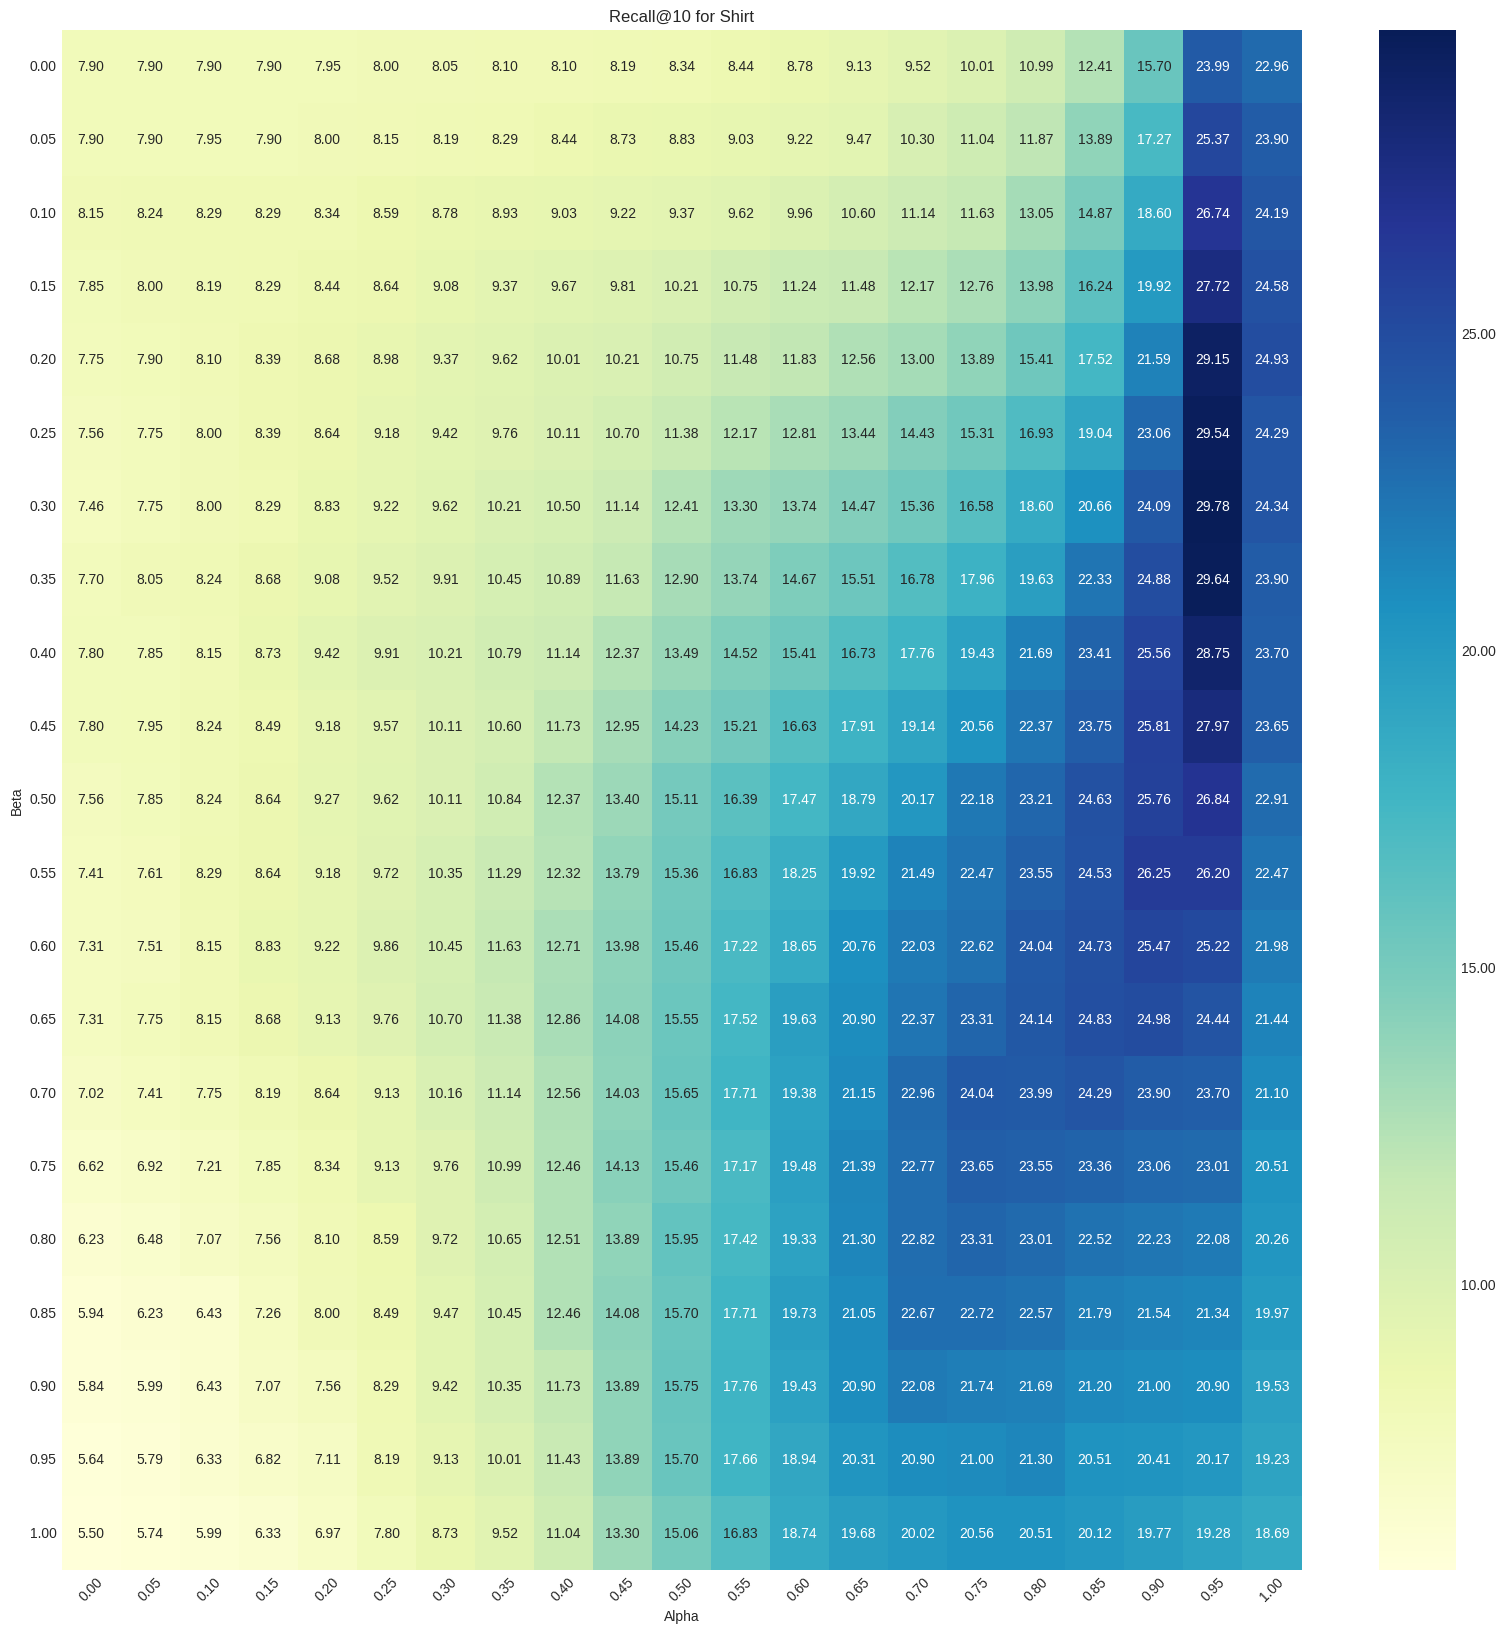

In [20]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

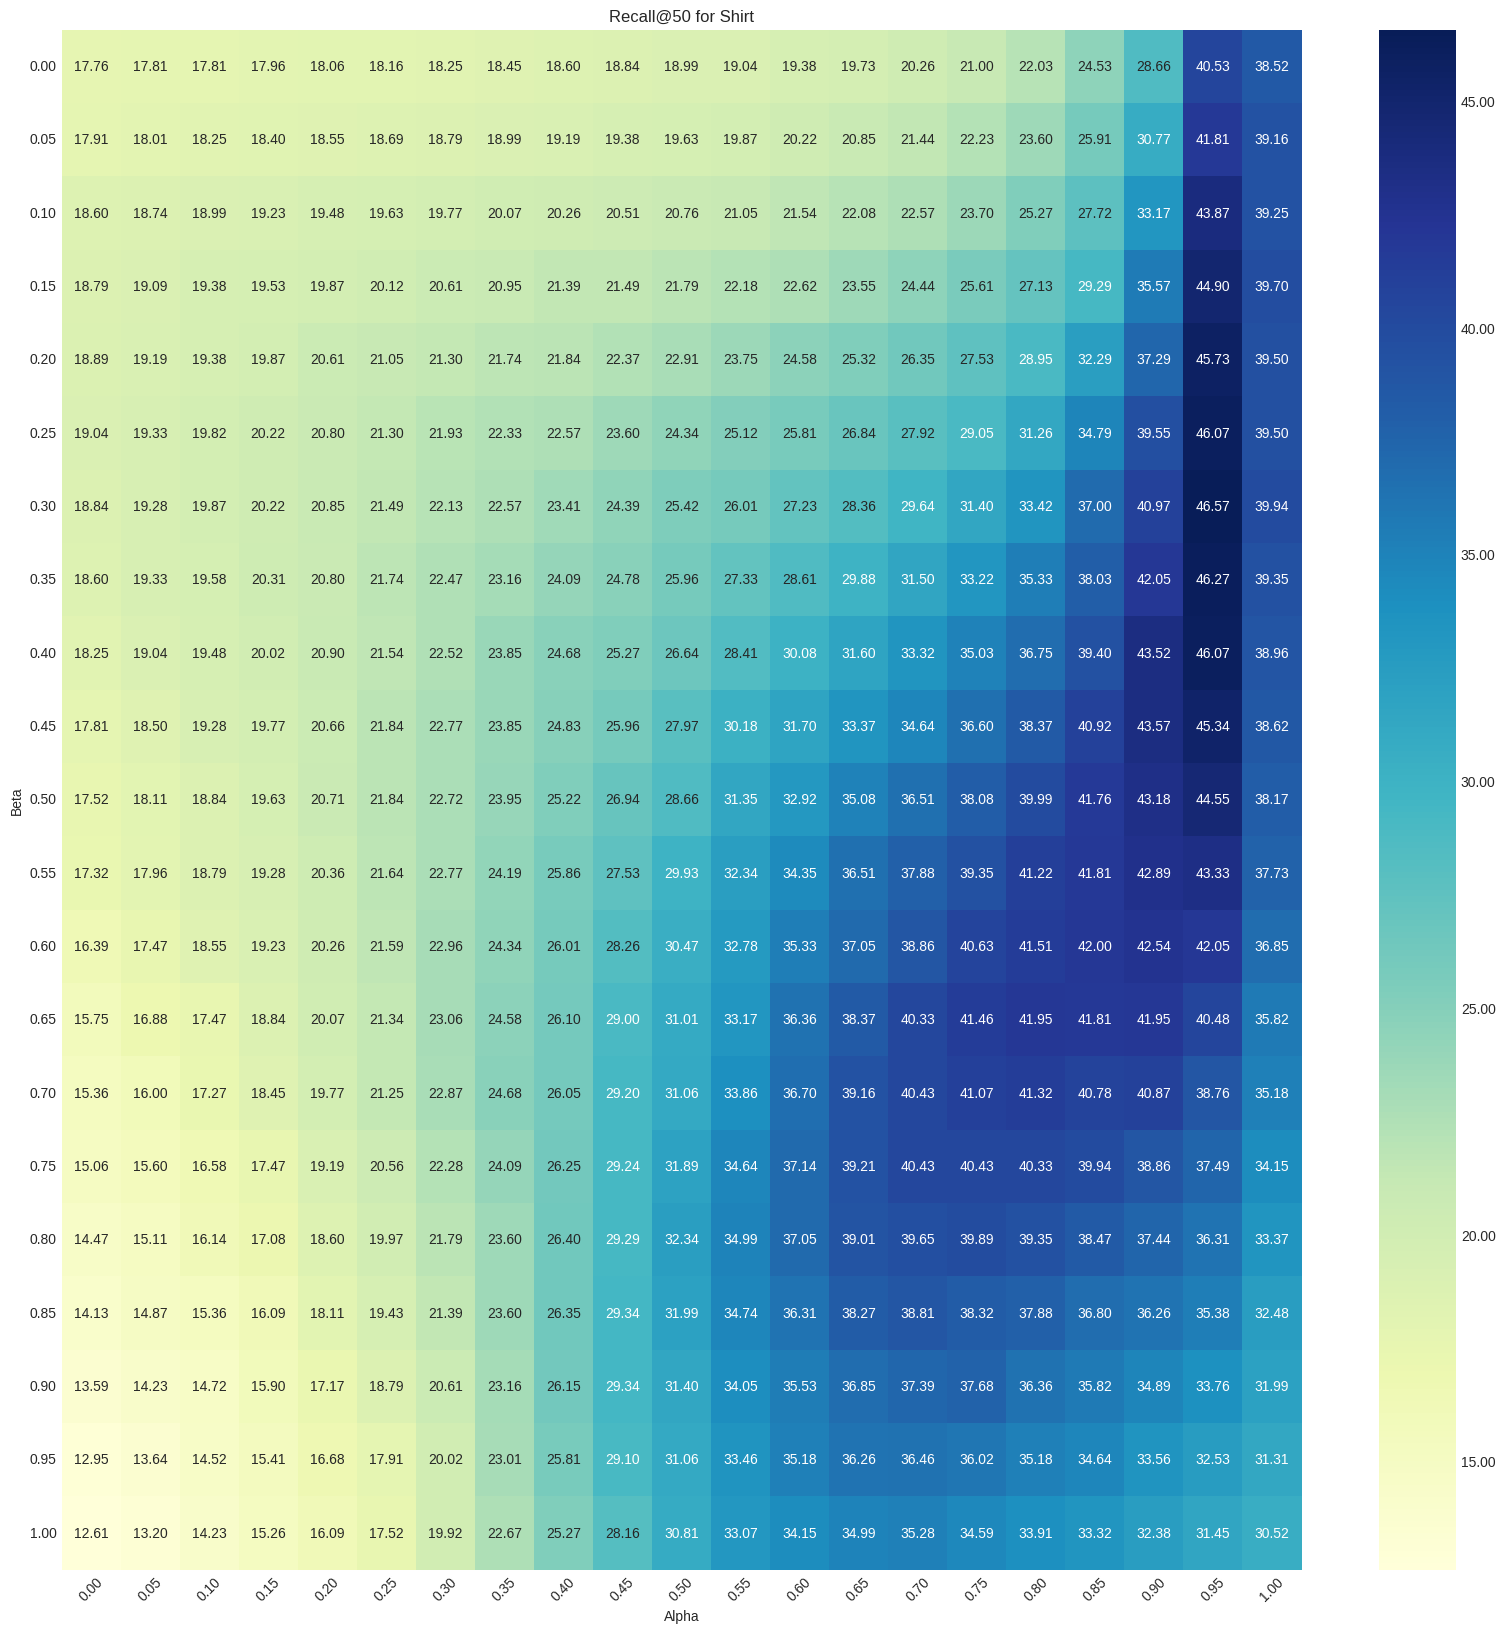

In [21]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

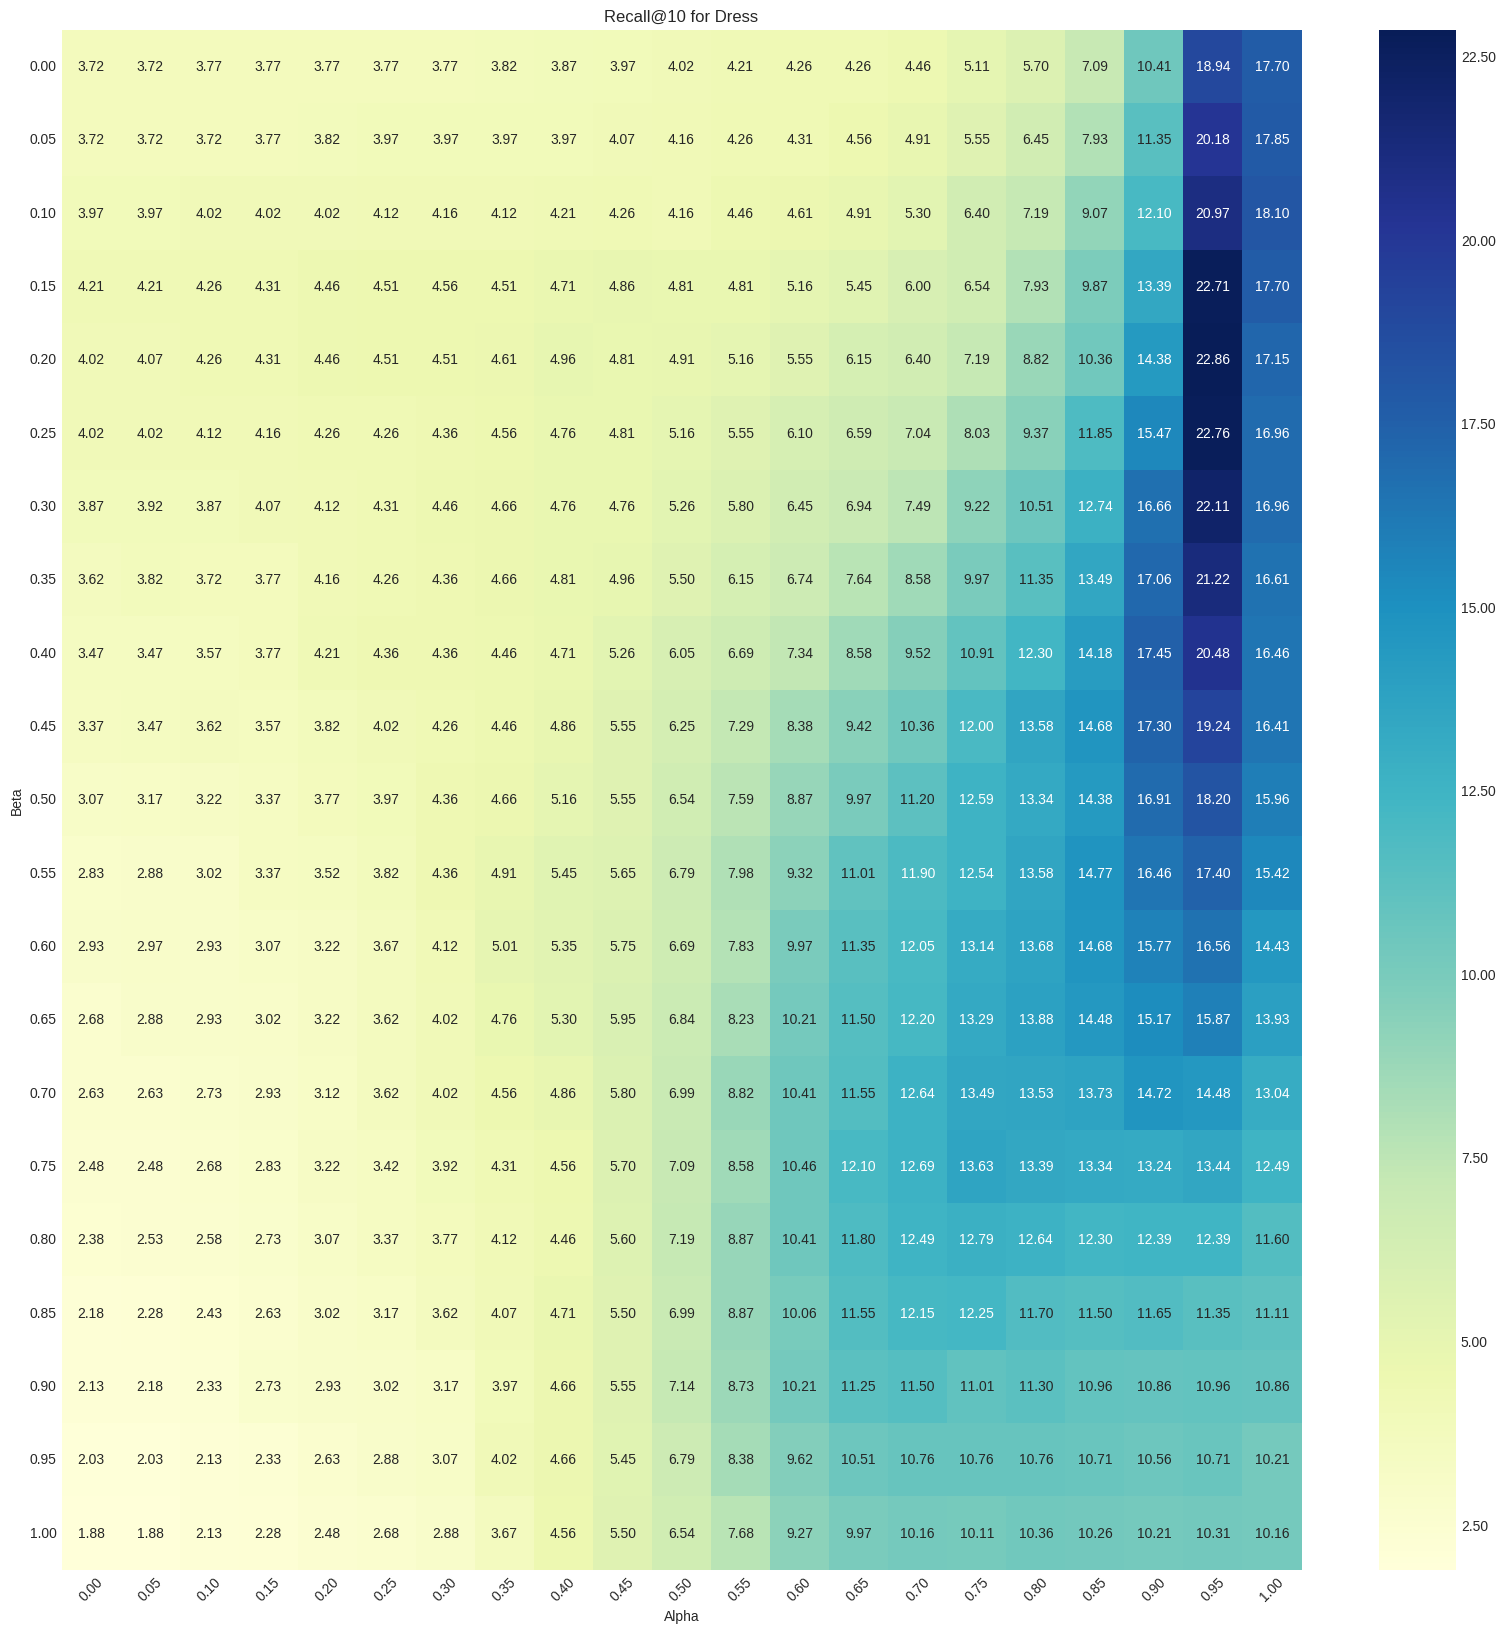

In [22]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

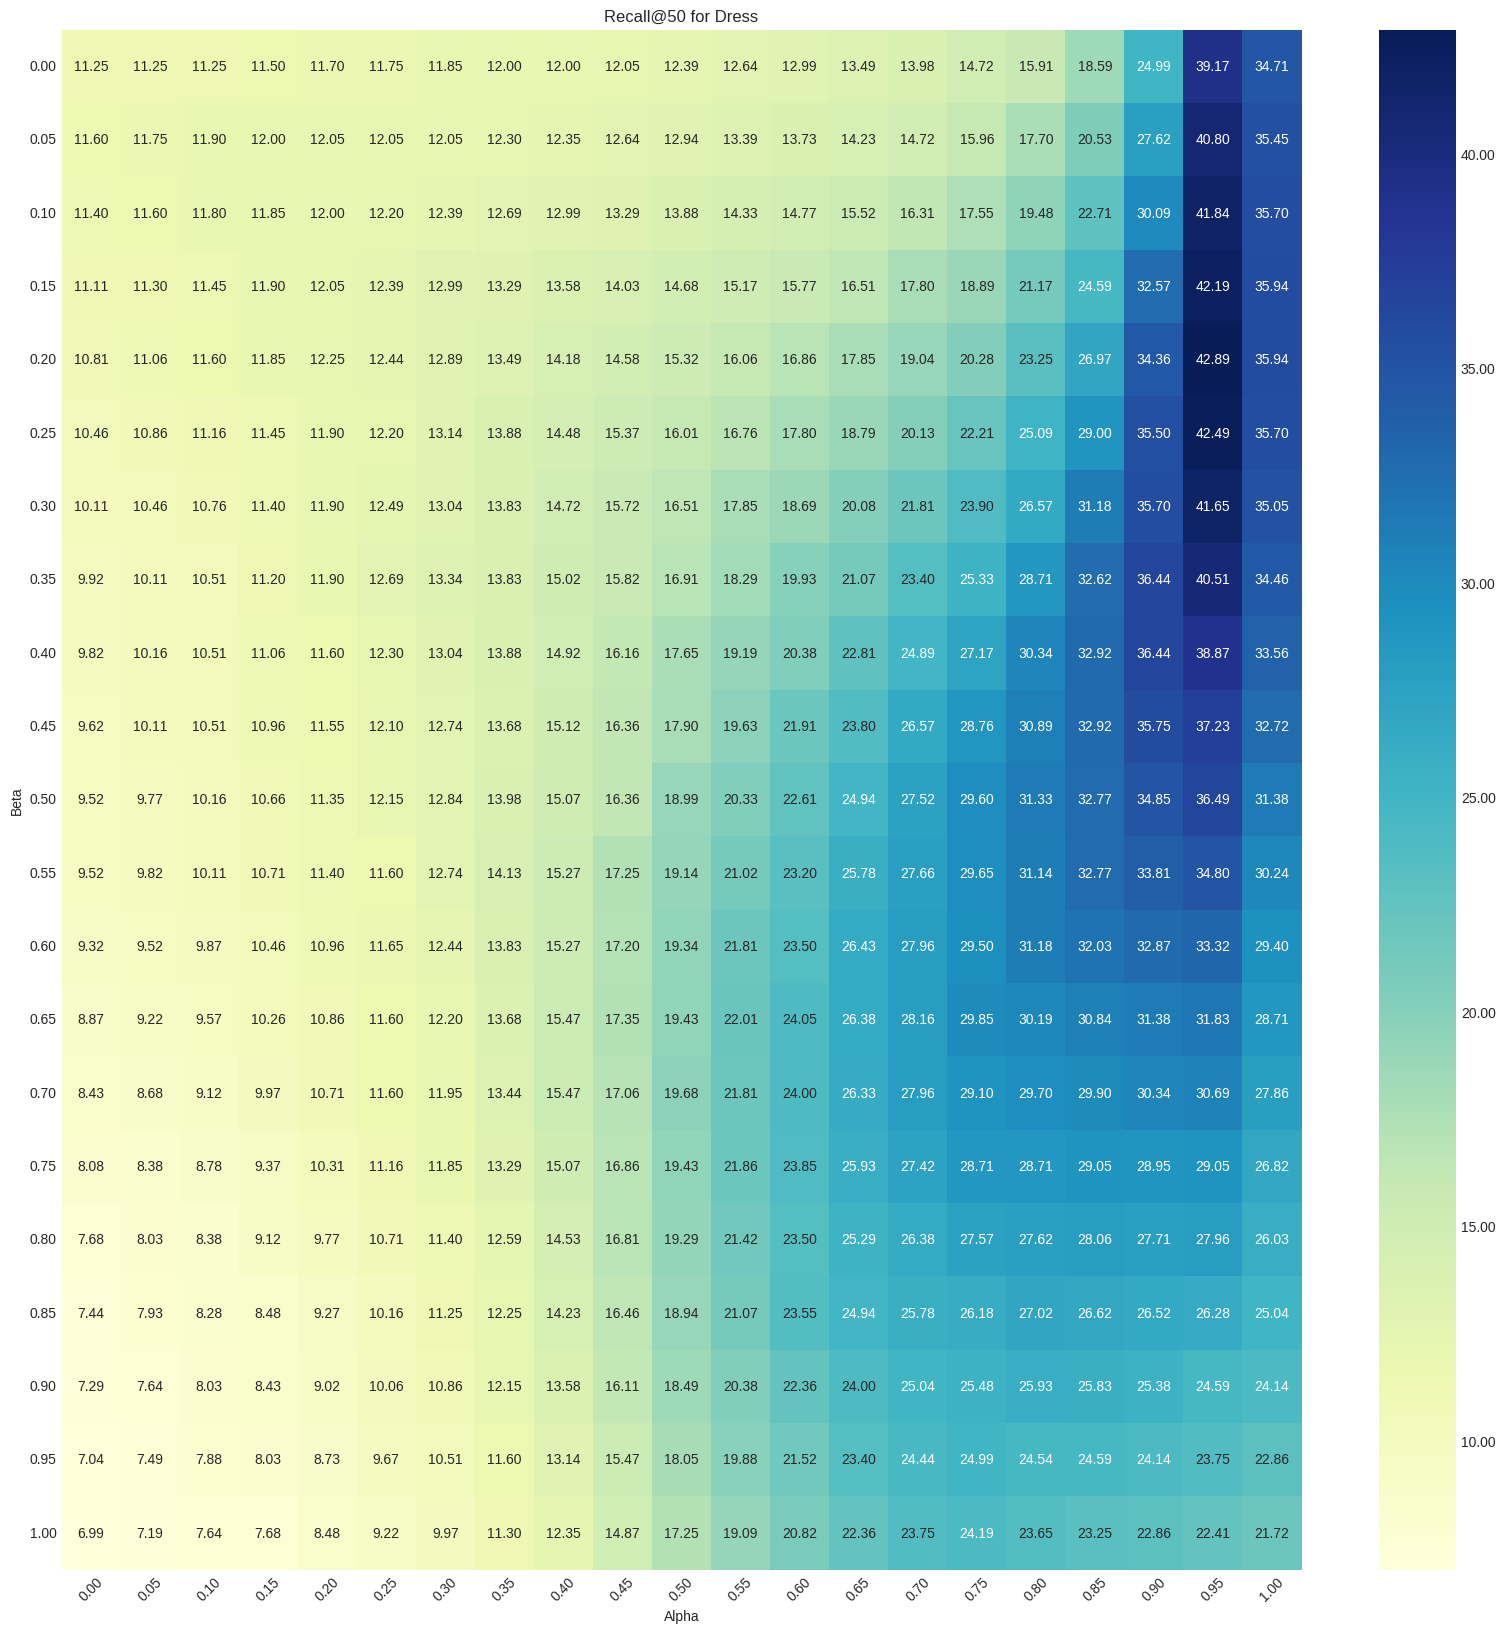

In [23]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

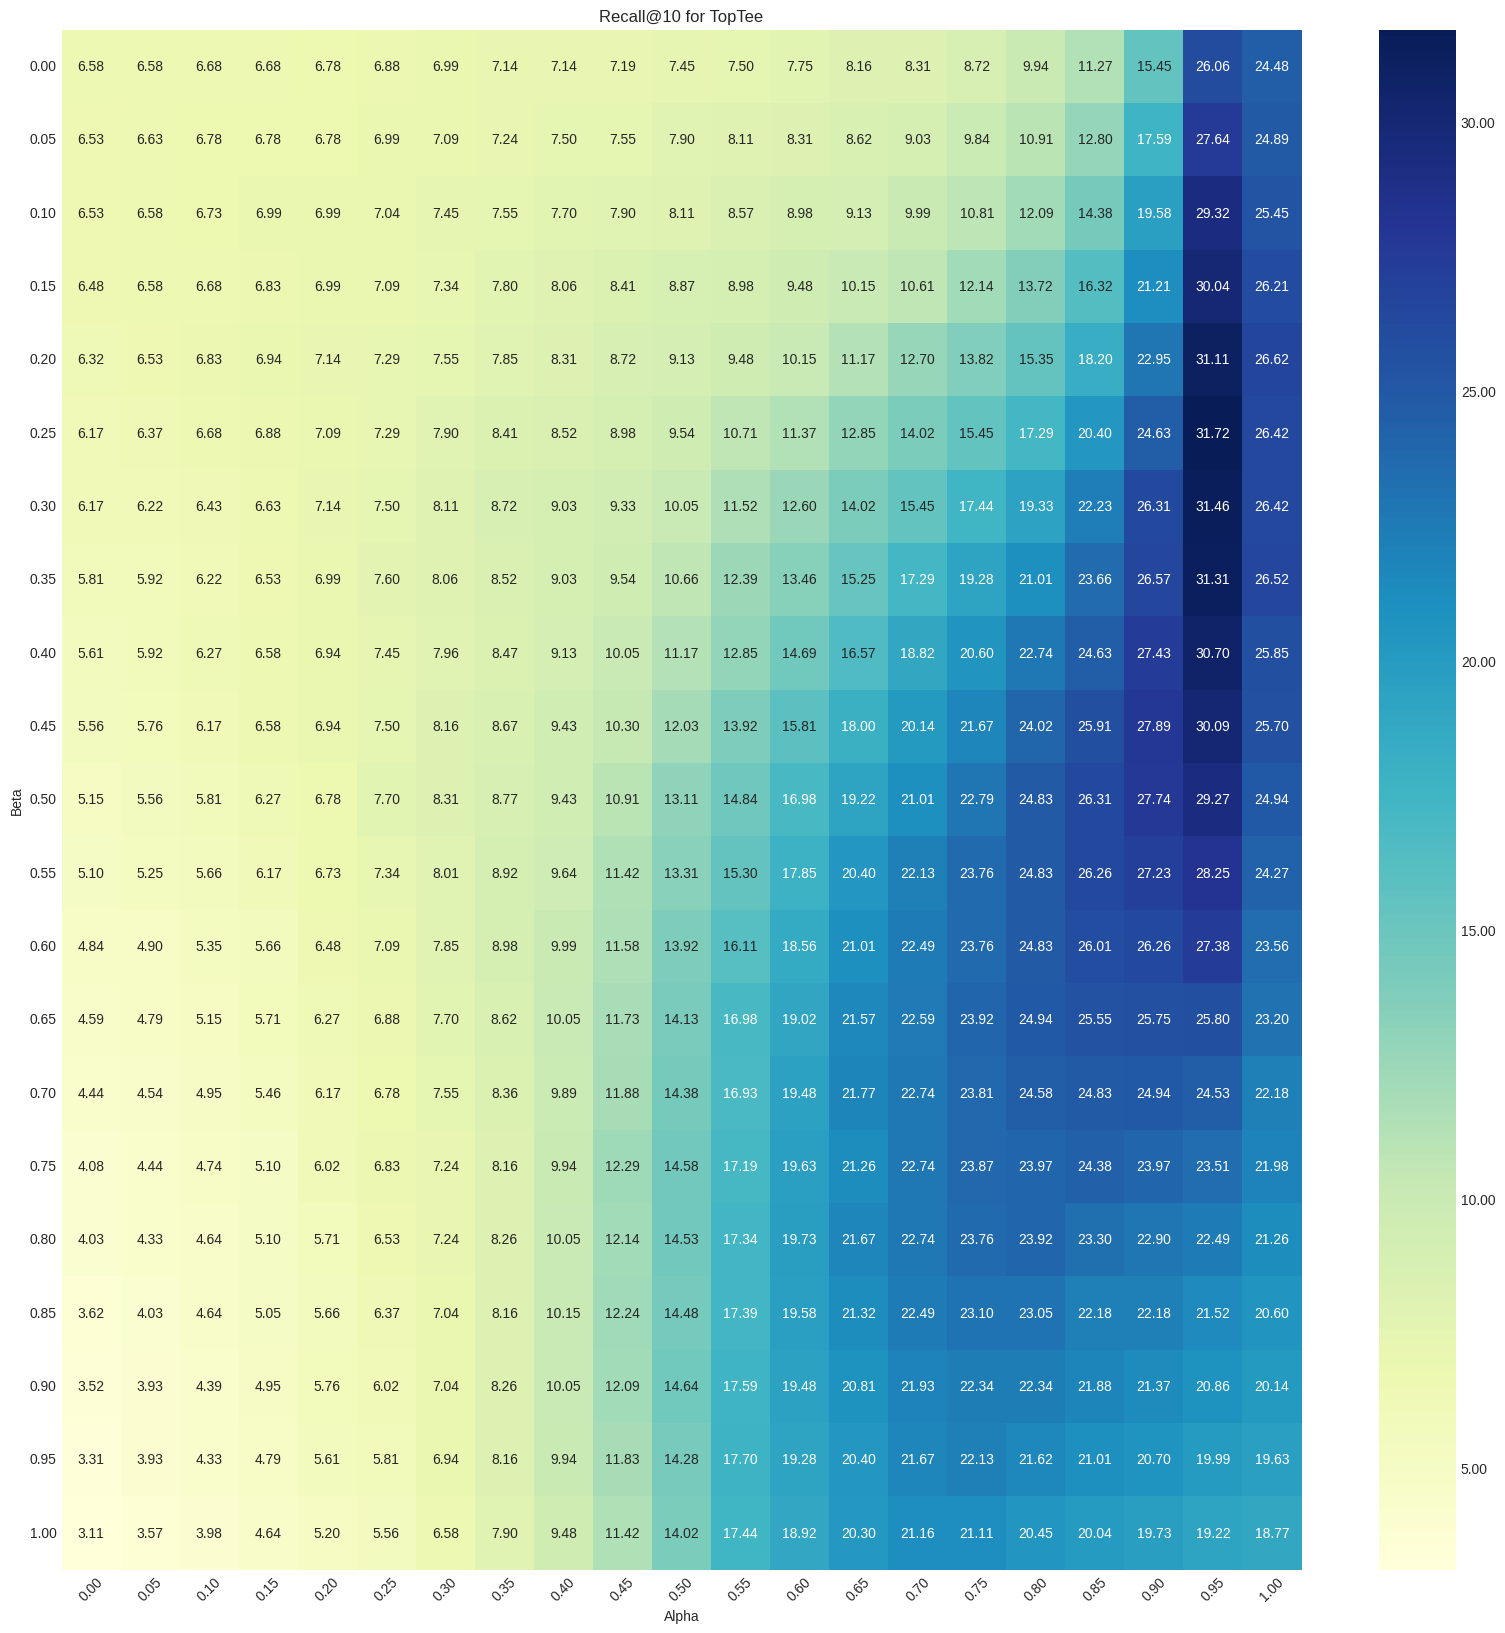

In [24]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

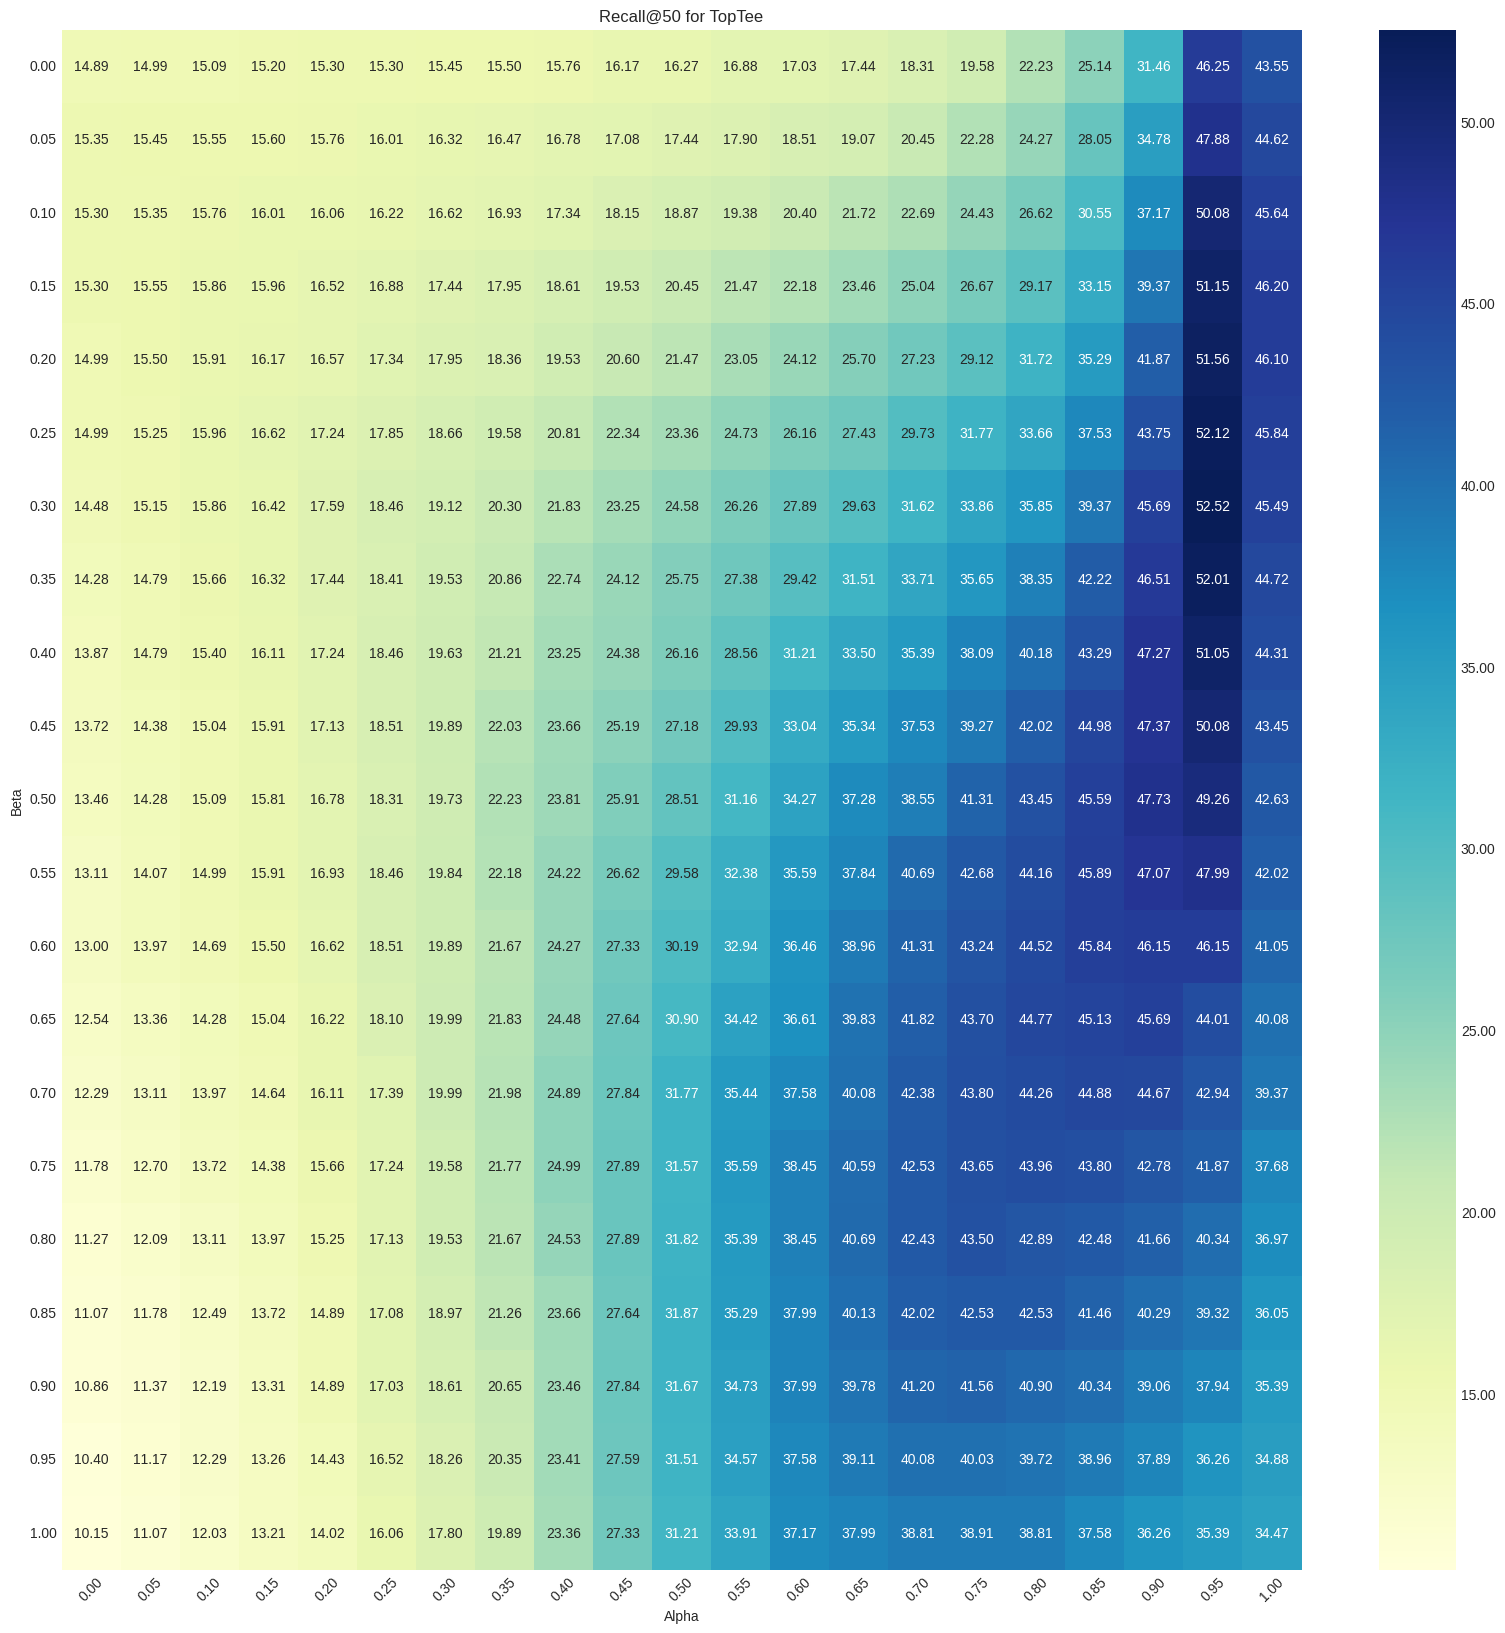

In [25]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

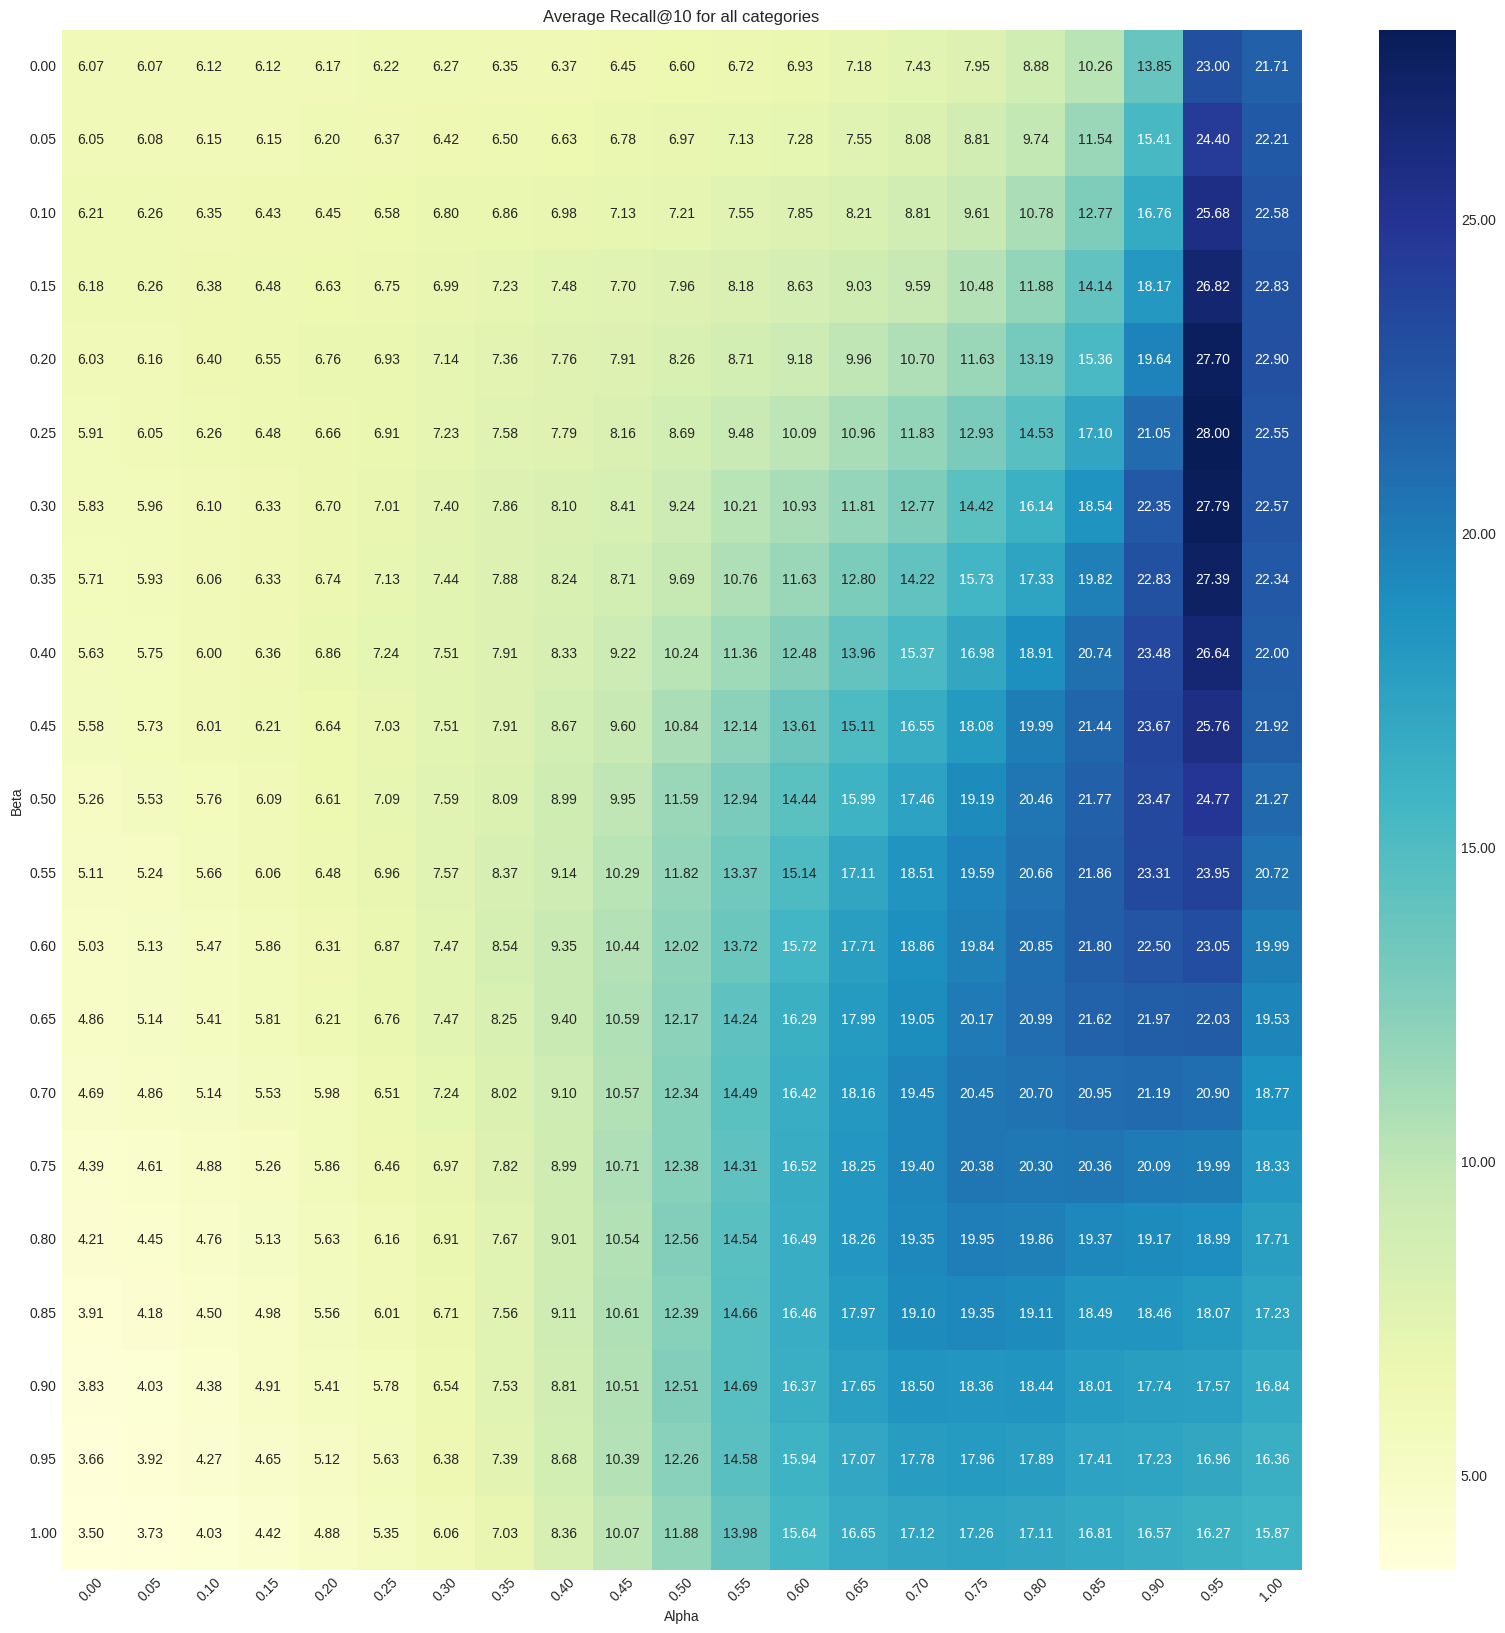

In [26]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

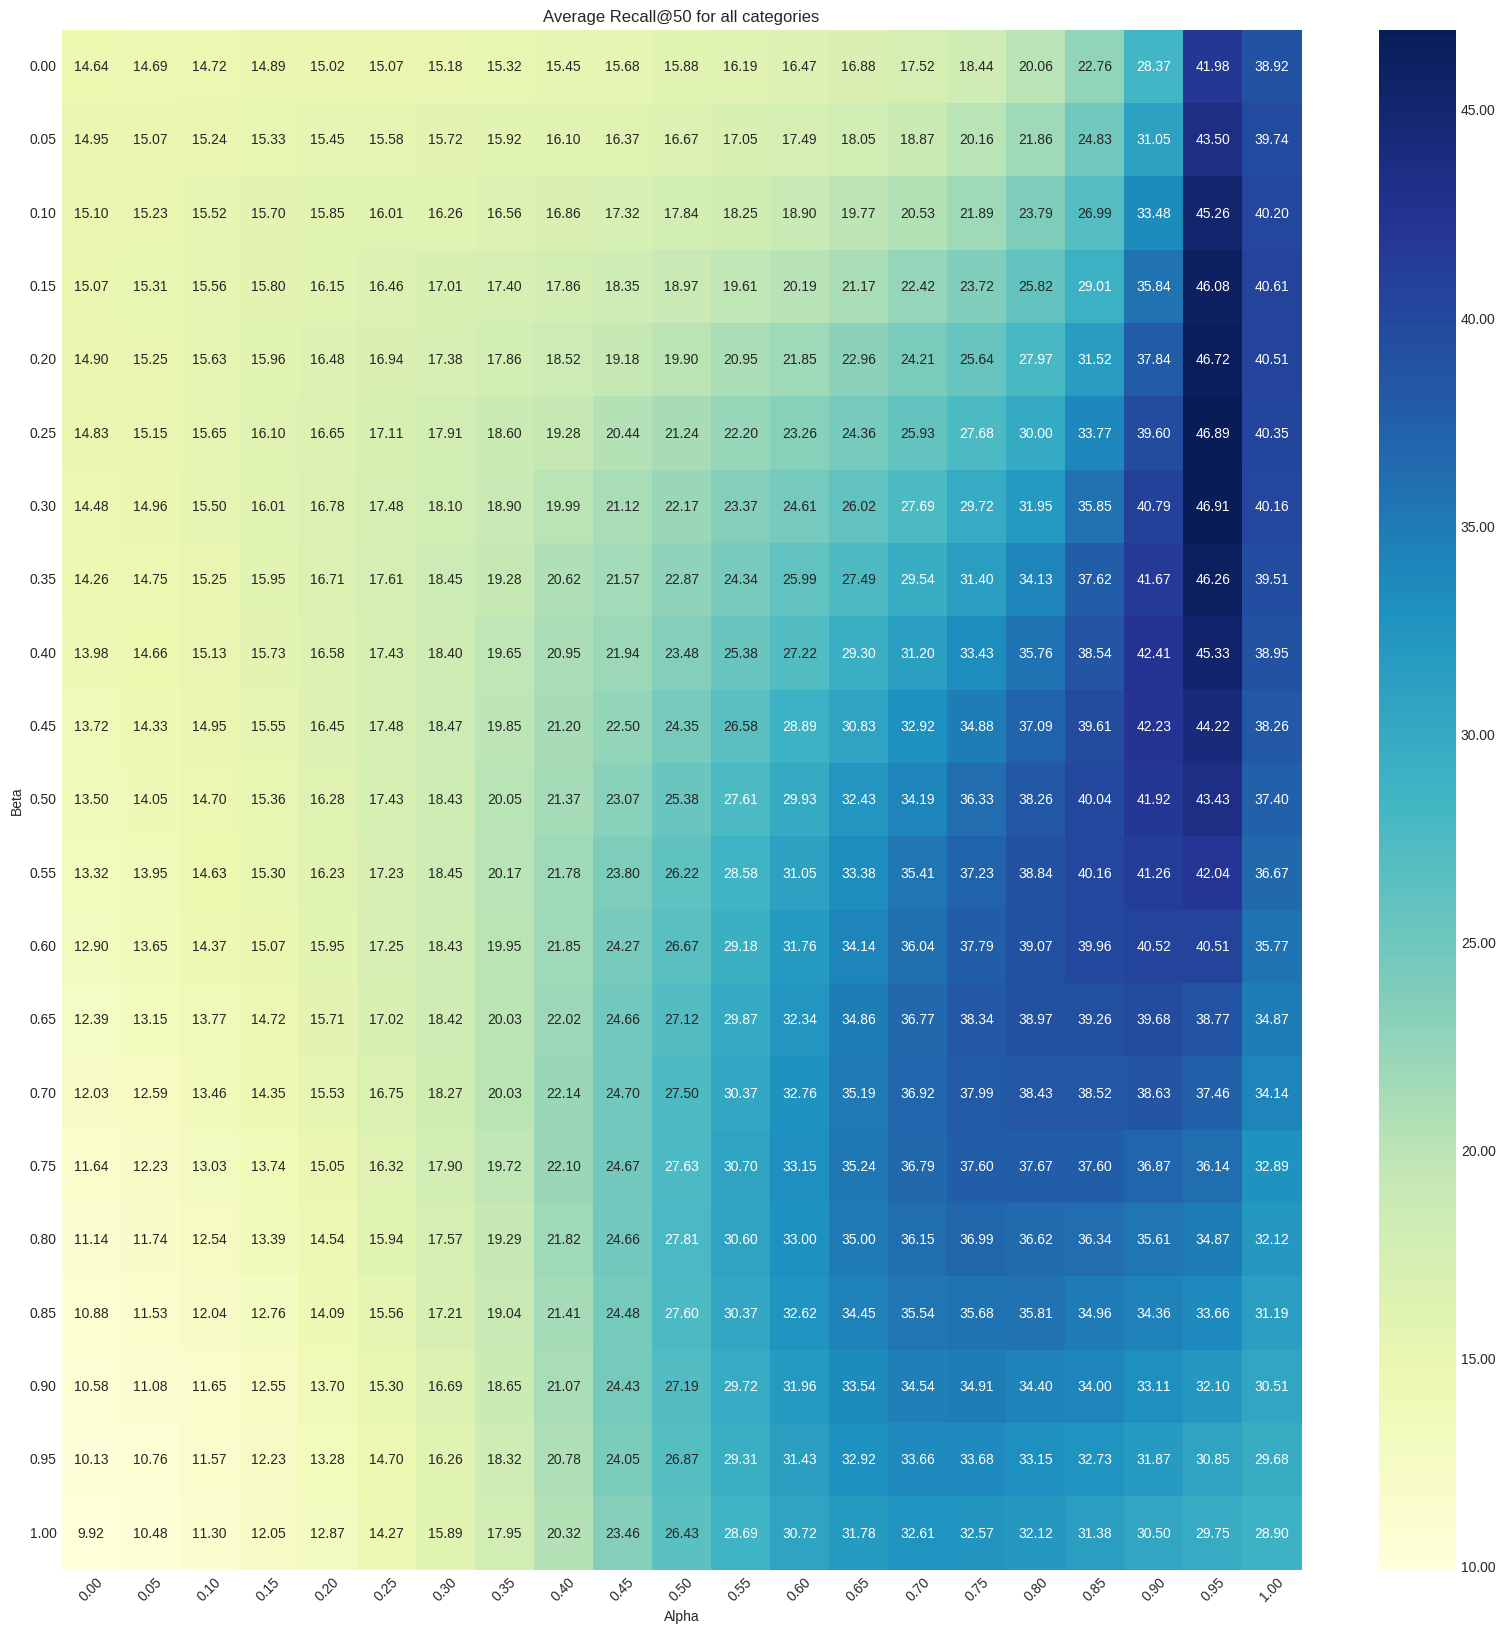

In [27]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [28]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val(
    'shirt',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 29.14622128009796
Recall at 50: 45.731109380722046


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [29]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val(
    'dress',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 22.85572588443756
Recall at 50: 42.88547337055206


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [30]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val(
    'toptee',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 31.106579303741455
Recall at 50: 51.55532956123352


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [31]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

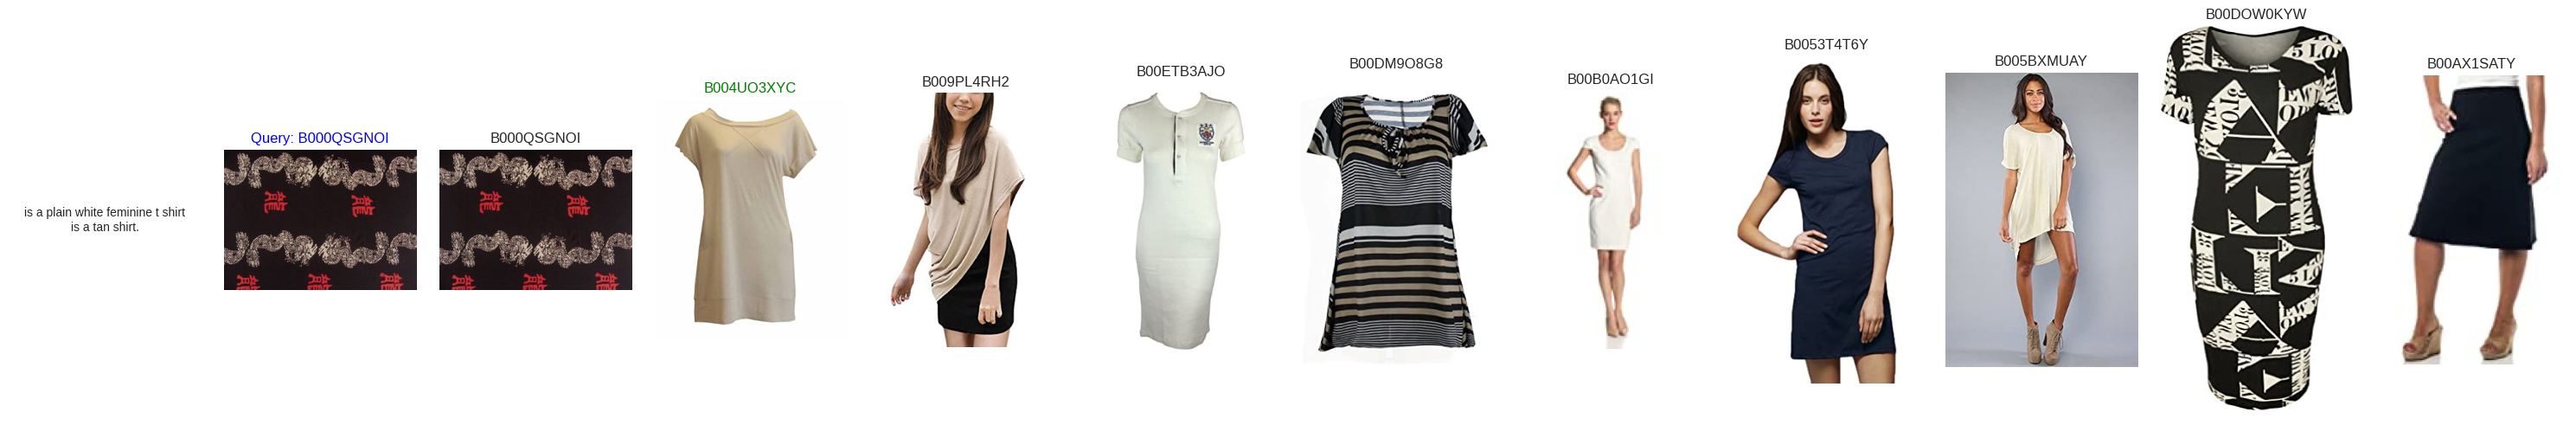

In [32]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [33]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val(
    'shirt',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 8.341511338949203
Recall at 50: 18.989205360412598


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [34]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val(
    'dress',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 4.015865176916122
Recall at 50: 12.394645810127258


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [35]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val(
    'toptee',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 7.445181161165237
Recall at 50: 16.267210245132446


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [36]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(453, [1, 6, 8, 11, 16, 19, 20, 21, 34, 40])

In [37]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(29, [84, 263, 281, 289, 376, 394, 419, 444, 457, 640])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [38]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(418, [1, 3, 4, 10, 11, 12, 16, 25, 27, 30])

In [39]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(23, [6, 109, 125, 169, 218, 496, 605, 618, 760, 930])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [40]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(518, [2, 3, 4, 7, 9, 10, 11, 13, 17, 20])

In [41]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(32, [170, 216, 230, 302, 379, 398, 502, 520, 523, 635])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

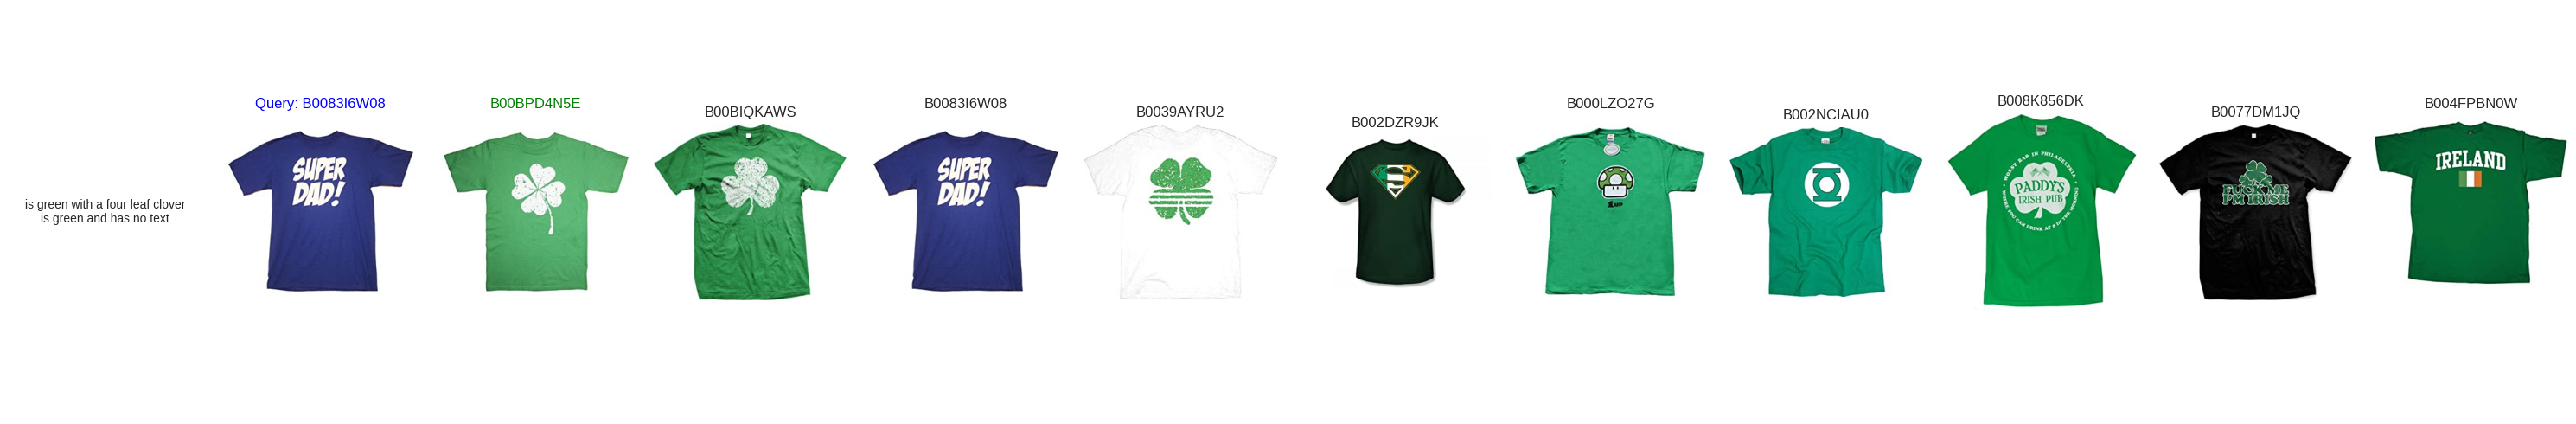

In [42]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

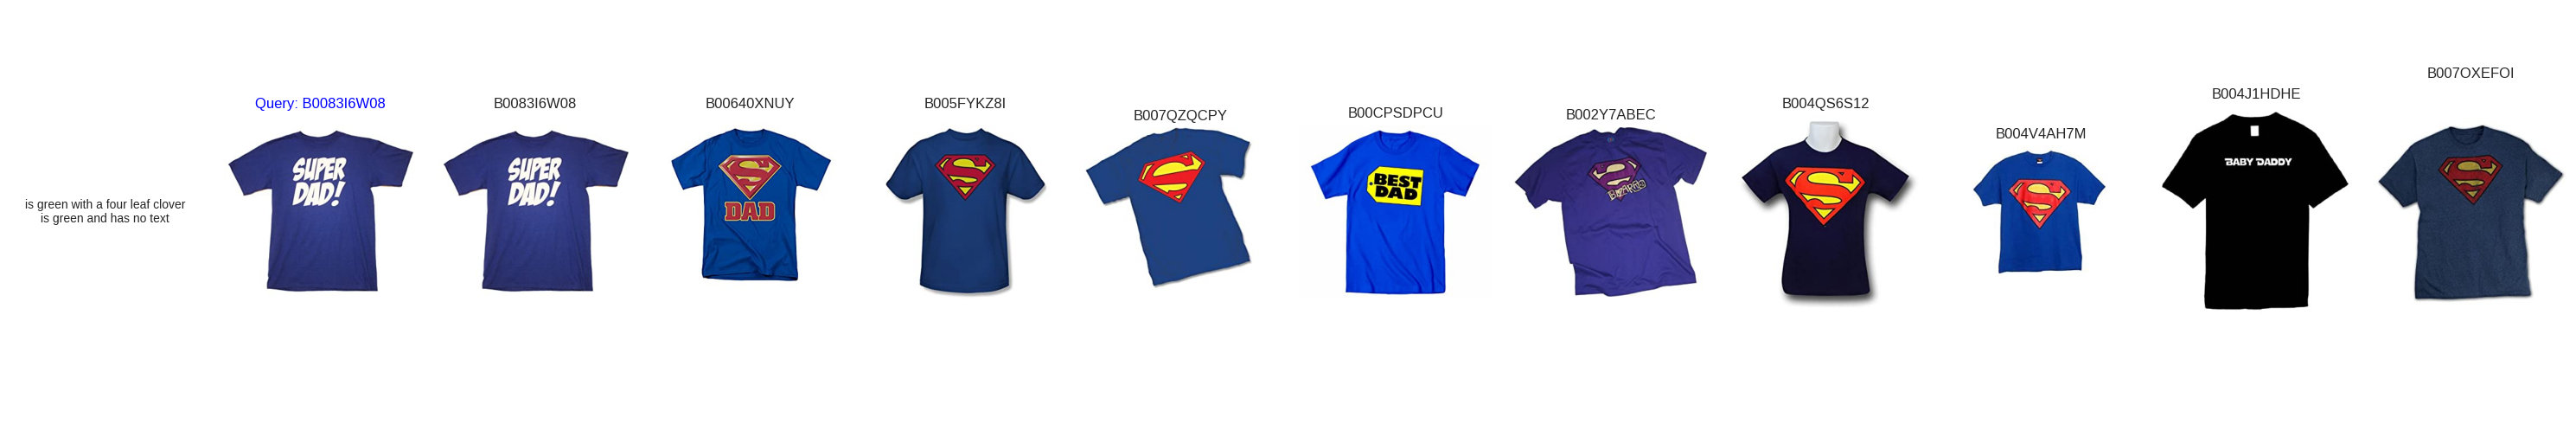

In [43]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

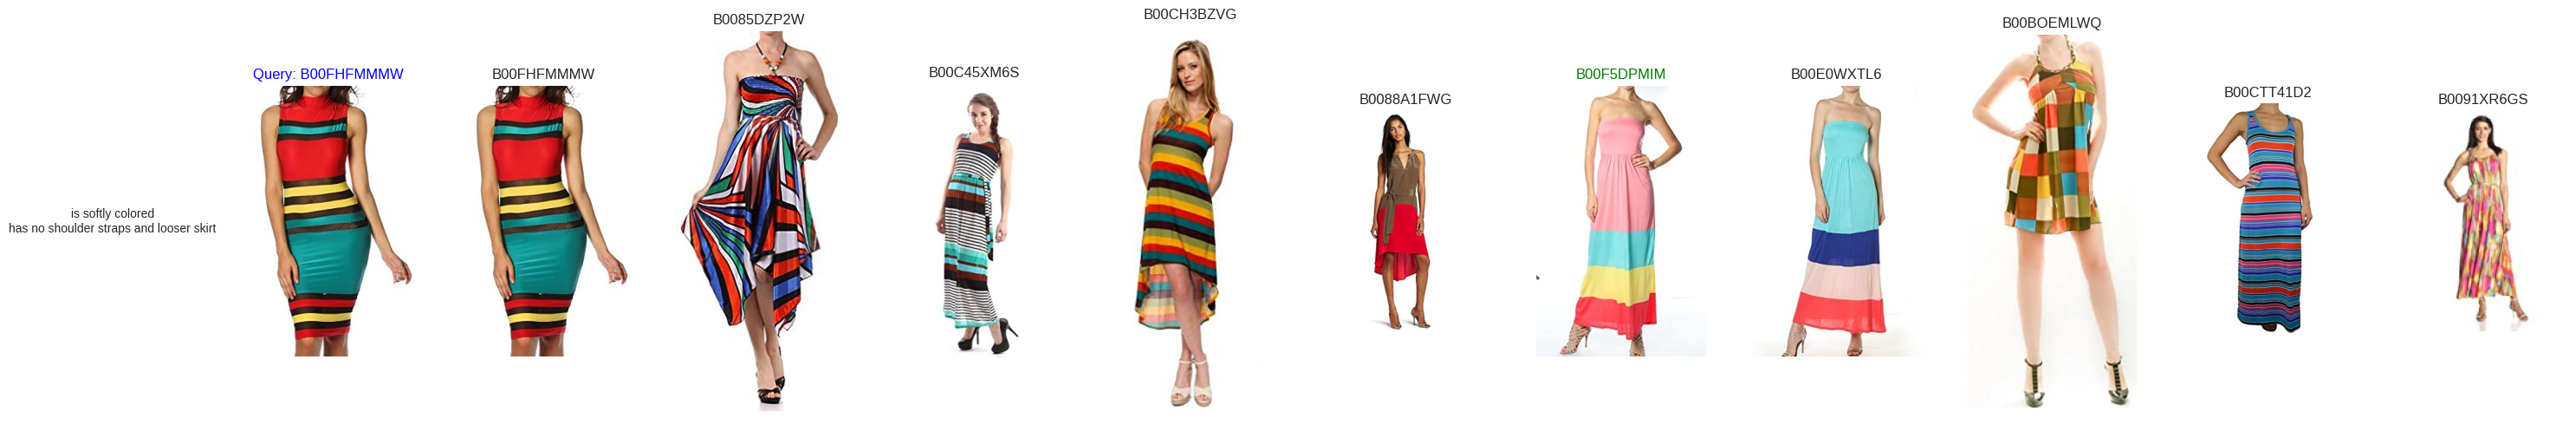

In [44]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

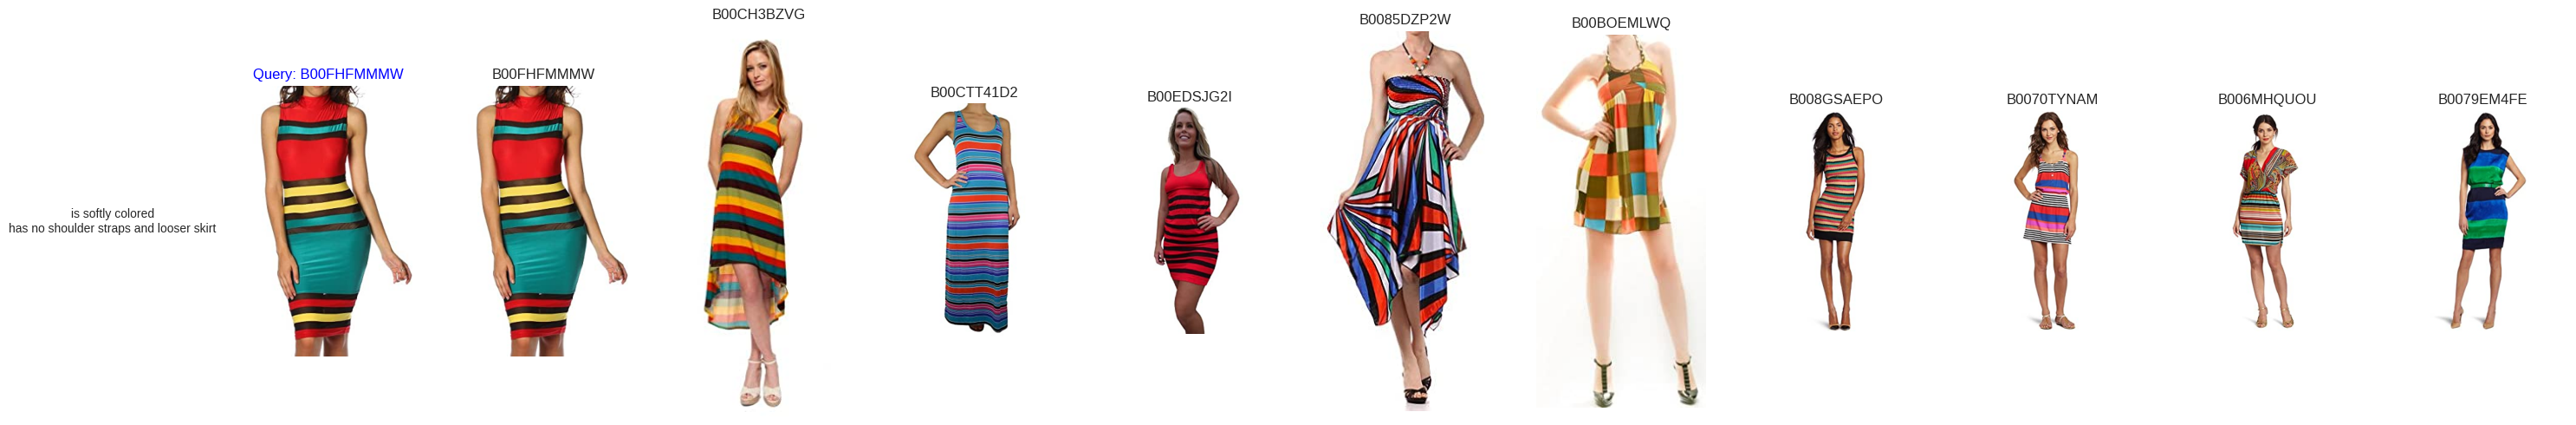

In [45]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

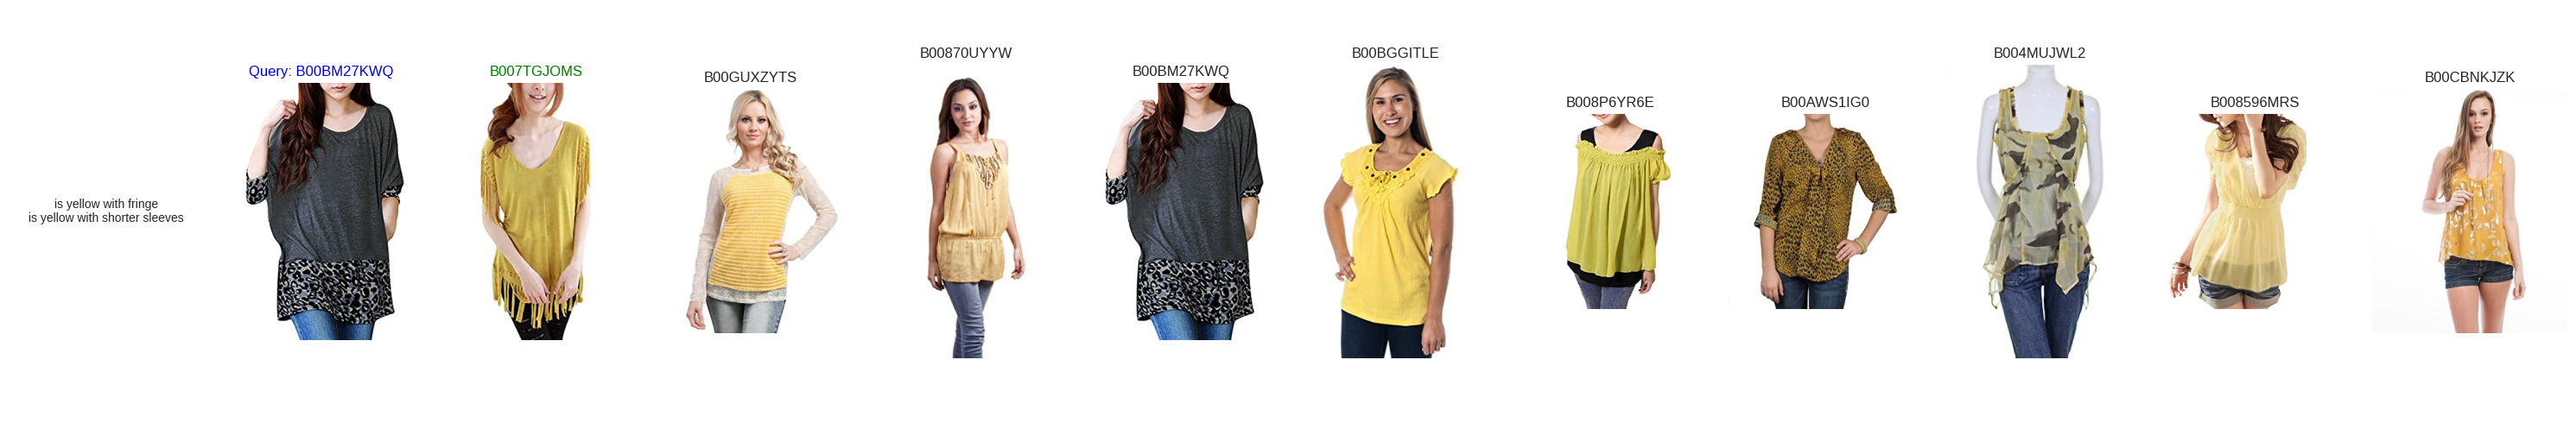

In [46]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

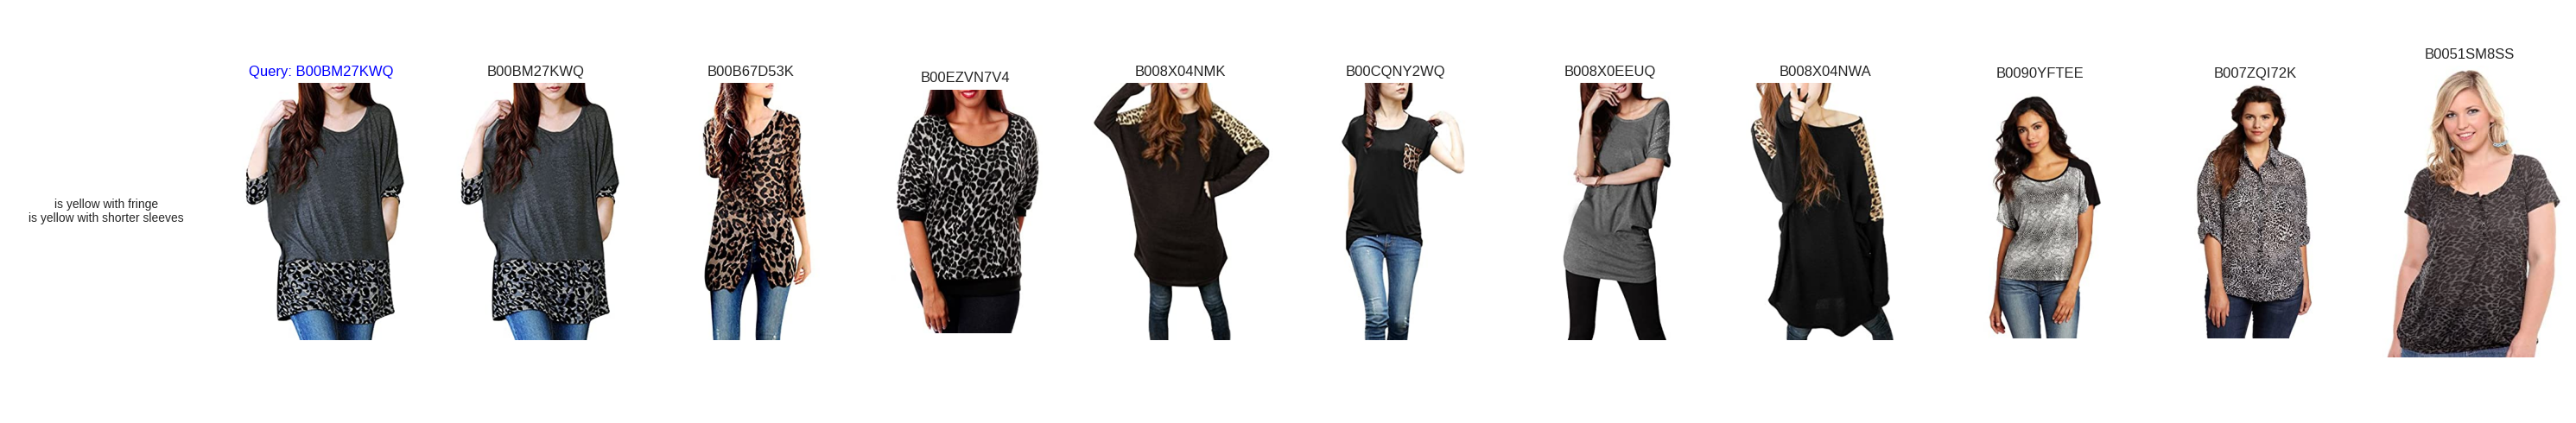

In [47]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)